In [1]:
from logging import config
import os
import datetime
from typing import Optional, Tuple
import json

os.environ["WANDB_NOTEBOOK_NAME"] = ".\Tianshow_Centralized_Training"

import numpy as np
import torch
from tianshou.data import Collector, VectorReplayBuffer, PrioritizedVectorReplayBuffer
from tianshou.env import DummyVectorEnv

from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager, RandomPolicy, RainbowPolicy
from tianshou.trainer import OffpolicyTrainer
from torch.utils.tensorboard import SummaryWriter

from LOTZ.LOTZ_env import LeadingOnesTrailingZerosEnv

# from TaskAllocation.RL_Policies.MultiHead_SISL import MultiHead_SISL
from TaskAllocation.RL_Policies.DNN_LOTZ import DNN_LOTZ
from TaskAllocation.RL_Policies.MultiHead_LOTZ import MultiHead_LOTZ
from TaskAllocation.RL_Policies.ATT_LOTZ import ATT_LOTZ
# from TaskAllocation.RL_Policies.CNN_SISL import CNN_SISL

from TaskAllocation.RL_Policies.Custom_Classes import CustomNet
from TaskAllocation.RL_Policies.Custom_Classes import CustomCollector
from TaskAllocation.RL_Policies.Custom_Classes import CustomParallelToAECWrapper


#----------------------------------#
from tianshou.env.pettingzoo_env import PettingZooEnv
from typing import Any
from gymnasium import spaces

def _reset(self, *args: Any, **kwargs: Any) -> tuple[dict, dict]:
        self.env.reset(*args, **kwargs)

        observation, reward, terminated, truncated, info = self.env.last()

        if isinstance(observation, dict) and "action_mask" in observation:
            observation_dict = {
                "agent_id": self.env.agent_selection,
                "obs": observation["observation"],
                "mask": [obm == 1 for obm in observation["action_mask"]],
            }
        else:
            if isinstance(self.action_space, spaces.Discrete):
                observation_dict = {
                    "agent_id": self.env.agent_selection,
                    "obs": observation,
                    "mask": [True] * self.env.action_space(self.env.agent_selection).n,
                }
            else:
                observation_dict = {
                    "agent_id": self.env.agent_selection,
                    "obs": observation,
                }

        return observation_dict, info
    
PettingZooEnv.reset = _reset
    
# --- Add specific modification to tianshou -----#
import wandb
from tianshou.utils import WandbLogger
from tianshou.utils.logger.base import LOG_DATA_TYPE
def new_write(self, step_type: str, step: int, data: LOG_DATA_TYPE) -> None:
    data[step_type] = step
    wandb.log(data)
WandbLogger.write = new_write 

#from tianshou_DQN import train
project = "LOTZ_Eval"
model  =  "MultiHead_LOTZ" #"MultiHead_SISL" 
test_num  =  "_NOV01"
policyModel  =  "DQN"

train_env_num = 20
test_env_num = 20

name = model + test_num

load_policy_name = f'policy_MultiHead_LOTZ_NOV01.pth'
save_policy_name = f'policy_{name}'
policy_path = "policy_LOTZ"

same_policy = True
load_model = False

# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = name + str(now)

log_path = os.path.join('./', "Logs", "dqn_sisl", log_name)

LOTZ_Config = {
    "string_length": 128,
    "n_agents": 2,
    "seed": 0,
    "m_steps": 256,
    "sp": 0
}

max_cycles = LOTZ_Config["m_steps"]
n_agents = 2

dqn_params = {"discount_factor": 0.95, 
              "estimation_step": 3, 
              "target_update_freq": 100 * max_cycles,
              "optminizer": "Adam",
              "lr": 1e-3 }

trainer_params = {"max_epoch": 500,
                  "step_per_epoch": 250 * max_cycles,
                  "step_per_collect": max_cycles * 50,
                  "episode_per_test": 20,
                  "batch_size" : max_cycles * 10 ,
                  "update_per_step": 1 / (max_cycles * 5), #Only run after close a Collect (run many times as necessary to meet the value)
                  "tn_eps_max": 0.15,
                  "ts_eps_max": 0.0,
                  }

runConfig = dqn_params
runConfig.update(trainer_params) 
runConfig.update(LOTZ_Config)

model_load_path = os.path.join(policy_path, load_policy_name)  
model_save_path = os.path.join(policy_path, save_policy_name)        
os.makedirs(os.path.join(policy_path), exist_ok=True)  
os.makedirs(os.path.join(log_path), exist_ok=True)

def _get_agents(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    policy_load_path = None,
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    
    env = _get_env()       
    agent_observation_space = env.observation_space
   
    action_shape = env.action_space

    print("Action_Shape: ", action_shape)
    print("agent_observation_space: ", agent_observation_space)
    
    device="cpu" #"cuda" if torch.cuda.is_available() else "cpu"          
    
    if agent_learn is None:      
        
        if model == "MultiHead_LOTZ":
            net = MultiHead_LOTZ(
                obs_shape=agent_observation_space,                
                action_shape=action_shape, 
                max_len = LOTZ_Config["string_length"],
                device=device
                
            ).to(device)

        if model == "DNN_LOTZ":
            net = DNN_LOTZ(
                obs_shape=agent_observation_space,                
                action_shape=action_shape,                
                device=device
                
            ).to(device)

        if model == "ATT_LOTZ":
            net = ATT_LOTZ(
                obs_shape=agent_observation_space,                
                action_shape=action_shape,                
                device=device
                
            ).to(device)
           

        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=dqn_params["lr"], weight_decay=0.0, amsgrad= False )                
    
        if policyModel == "DQN":
            agent_learn = DQNPolicy(
                model=net,
                optim=optim,
                action_space = action_shape,
                discount_factor= dqn_params["discount_factor"],
                estimation_step=dqn_params["estimation_step"],
                target_update_freq=dqn_params["target_update_freq"],
                reward_normalization = False,
                clip_loss_grad = False 
            ) 
                     

        if policyModel == "Rainbow":
            agent_learn = RainbowPolicy(
                model=net.to(device),
                optim=optim,
                action_space = action_shape,
                num_atoms= 5,
                discount_factor= dqn_params["discount_factor"],
                estimation_step=dqn_params["estimation_step"],
                target_update_freq=dqn_params["target_update_freq"],
            ) 
         
 
        if load_model is True:
            # Load the saved checkpoint             
            agent_learn.load_state_dict(torch.load(model_load_path))
            print(f'Loaded-> {model_load_path}')
                   
        #print(env.agents)
        #agents = [agent_learn for _ in range(len(env.agents))]
        
        agents = [agent_learn for _ in range(len(env.agents))]

        
    policy = MultiAgentPolicyManager(policies = agents, env=env)  
        
    return policy, optim, env.agents

def _get_env():
    """This function is needed to provide callables for DummyVectorEnv."""   
    # env_paralell = MultiUAVEnv()  
    # env = pursuit_v4.env()
    env = LeadingOnesTrailingZerosEnv(
        string_length= LOTZ_Config["string_length"], 
        n_agents=LOTZ_Config["n_agents"], 
        seed=LOTZ_Config["seed"], 
        m_steps = LOTZ_Config["m_steps"], 
        sp = LOTZ_Config["sp"] )
    
    #env = parallel_to_aec_wrapper(env_paralell)    
    # env = CustomParallelToAECWrapper(env_paralell)
    
    return PettingZooEnv(env)
    # return env

print(json.dumps(runConfig, indent=4))

{
    "discount_factor": 0.95,
    "estimation_step": 3,
    "target_update_freq": 25600,
    "optminizer": "Adam",
    "lr": 0.001,
    "max_epoch": 500,
    "step_per_epoch": 64000,
    "step_per_collect": 12800,
    "episode_per_test": 20,
    "batch_size": 2560,
    "update_per_step": 0.00078125,
    "tn_eps_max": 0.15,
    "ts_eps_max": 0.0,
    "string_length": 128,
    "n_agents": 2,
    "seed": 0,
    "m_steps": 256,
    "sp": 0
}


In [2]:
if __name__ == "__main__":
                        
    torch.set_grad_enabled(True) 
   
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(train_env_num)])
    test_envs = DummyVectorEnv([_get_env for _ in range(test_env_num)]) 

    # seed
    seed = 0
    np.random.seed(seed)
    
    torch.manual_seed(seed)

    train_envs.seed(seed)
    test_envs.seed(seed)

    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents()    

    agentsBuffer = PrioritizedVectorReplayBuffer( 300_000, len(train_envs), alpha=0.6, beta=0.4)  
    # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        # VectorReplayBuffer(300_000, len(train_envs)),
        agentsBuffer,
        #ListReplayBuffer(100000)       
        exploration_noise=True             
    )
    test_collector = Collector(policy, test_envs, exploration_noise=False)
     
    print("Buffer Warming Up ")    
    for i in range(1):#int(trainer_params['batch_size'] / (300 * 10 ) )):
        
        train_collector.collect(n_episode=train_env_num)#,random=True) #trainer_params['batch_size'] * train_env_num))
        #train_collector.collect(n_step=300 * 10)
        print(".", end="") 
    
    len_buffer = len(train_collector.buffer) #/ (SISL_Config["max_cycles"] * SISL_Config["n_pursuers"])
    print("\nBuffer Lenght: ", len_buffer ) 
    
    info = { "Buffer"  : "ReplayBuffer", " Warmup_ep" : len_buffer}
    # ======== tensorboard logging setup =========                       
    logger = WandbLogger(
        train_interval = runConfig["m_steps"] * runConfig["n_agents"] ,
        test_interval = 1,#runConfig["max_cycles"] * runConfig["n_pursuers"],
        update_interval = runConfig["m_steps"],
        save_interval = 1,
        write_flush = True,
        project = project,
        name = log_name,
        entity = None,
        run_id = log_name,
        config = runConfig,
        monitor_gym = True )
    
    writer = SummaryWriter(log_path)    
    writer.add_text("args", str(runConfig))    
    logger.load(writer)
    
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):                
        
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path + ".pth")
        print("Best Saved")
        

    def stop_fn(mean_rewards):
        return mean_rewards >= 99999939.0

    def train_fn(epoch, env_step):
        epsilon = trainer_params['tn_eps_max'] - (trainer_params['tn_eps_max'] - trainer_params['tn_eps_max']/100)*(epoch/trainer_params['max_epoch'])          
        if same_policy:
            policy.policies[agents[0]].set_eps(epsilon)
        else:
            policy.policies['R_agent0'].set_eps(epsilon)
            policy.policies['F_agent0'].set_eps(epsilon)
        
        # if env_step % 500 == 0:
            # logger.write("train/env_step", env_step, {"train/eps": eps})


    def test_fn(epoch, env_step):
        epsilon = trainer_params['ts_eps_max']#0.01#max(0.001, 0.1 - epoch * 0.001)
        if same_policy:
            policy.policies[agents[0]].set_eps(epsilon)
        else:
            policy.policies['R_agent0'].set_eps(epsilon)
            policy.policies['F_agent0'].set_eps(epsilon)

        
    def reward_metric(rews):       
        #print(rews)
        return rews#[:, 1]

    # # ======== Step 5: Run the trainer =========
    offPolicyTrainer = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,  
        buffer= agentsBuffer,      
        max_epoch=trainer_params['max_epoch'],
        step_per_epoch=trainer_params['step_per_epoch'],
        step_per_collect=trainer_params['step_per_collect'],        
        episode_per_test= trainer_params['episode_per_test'],
        batch_size=trainer_params['batch_size'],
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=trainer_params['update_per_step'],
        logger=logger,
        test_in_train=False,
        reward_metric=reward_metric,
        show_progress = True 
               
        )
    
    result = offPolicyTrainer.run()
    writer.close()
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[0]])")

Action_Shape:  Discrete(128)
agent_observation_space:  Box(0, 1, (128,), int32)
Buffer Warming Up 


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find .\Tianshow_Centralized_Training.


.
Buffer Lenght:  5120


wandb: Currently logged in as: andrekuros. Use `wandb login --relogin` to force relogin
d:\Python310\lib\site-packages\wandb\sdk\lib\ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Best Saved


Epoch #1: 64001it [01:44, 611.38it/s, agent0/loss=8026.417, env_step=64000, len=256, n/ep=40, n/st=12800, rew=-4196.77]                            


Epoch #1: test_reward: -4212.450000 ± 4212.554053, best_reward: -3248.600000 ± 3989.326922 in #0


Epoch #2: 64001it [01:38, 653.00it/s, agent0/loss=7985.577, env_step=128000, len=256, n/ep=60, n/st=12800, rew=-4194.57]                           


Epoch #2: test_reward: -4206.675000 ± 4206.930469, best_reward: -3248.600000 ± 3989.326922 in #0


Epoch #3: 64001it [01:31, 696.10it/s, agent0/loss=5438.747, env_step=192000, len=256, n/ep=40, n/st=12800, rew=-1892.00]                            


Best Saved
Epoch #3: test_reward: -1022.350000 ± 1032.302682, best_reward: -1022.350000 ± 1032.302682 in #3


Epoch #4: 64001it [01:29, 714.69it/s, agent0/loss=3684.639, env_step=256000, len=256, n/ep=60, n/st=12800, rew=-1855.08]                            


Best Saved
Epoch #4: test_reward: -983.575000 ± 998.208893, best_reward: -983.575000 ± 998.208893 in #4


Epoch #5: 64001it [01:46, 598.36it/s, agent0/loss=5063.953, env_step=320000, len=256, n/ep=40, n/st=12800, rew=-1756.71]                            


Best Saved
Epoch #5: test_reward: -947.900000 ± 962.069535, best_reward: -947.900000 ± 962.069535 in #5


Epoch #6: 64001it [01:35, 668.40it/s, agent0/loss=6487.090, env_step=384000, len=256, n/ep=60, n/st=12800, rew=-3748.80]                            


Best Saved
Epoch #6: test_reward: -444.075000 ± 569.985982, best_reward: -444.075000 ± 569.985982 in #6


Epoch #7: 64001it [01:32, 688.69it/s, agent0/loss=18802.728, env_step=448000, len=256, n/ep=40, n/st=12800, rew=343.50]                            


Epoch #7: test_reward: -1991.325000 ± 3567.677861, best_reward: -444.075000 ± 569.985982 in #6


Epoch #8: 64001it [01:31, 702.38it/s, agent0/loss=51040.818, env_step=512000, len=256, n/ep=60, n/st=12800, rew=-2563.53]                            


Epoch #8: test_reward: -2540.975000 ± 3659.807881, best_reward: -444.075000 ± 569.985982 in #6


Epoch #9: 64001it [01:27, 729.18it/s, agent0/loss=70259.653, env_step=576000, len=256, n/ep=40, n/st=12800, rew=-2833.97]                            


Epoch #9: test_reward: -2665.425000 ± 3625.356706, best_reward: -444.075000 ± 569.985982 in #6


Epoch #10: 64001it [01:34, 677.83it/s, agent0/loss=70899.383, env_step=640000, len=256, n/ep=60, n/st=12800, rew=-2828.10]                            


Epoch #10: test_reward: -2916.100000 ± 3693.544793, best_reward: -444.075000 ± 569.985982 in #6


Epoch #11: 64001it [01:29, 717.88it/s, agent0/loss=71768.542, env_step=704000, len=256, n/ep=40, n/st=12800, rew=-2948.59]                            


Epoch #11: test_reward: -2919.650000 ± 3692.876389, best_reward: -444.075000 ± 569.985982 in #6


Epoch #12: 64001it [01:19, 803.19it/s, agent0/loss=51107.139, env_step=768000, len=256, n/ep=60, n/st=12800, rew=-3204.69]                            


Epoch #12: test_reward: -3206.950000 ± 3890.217738, best_reward: -444.075000 ± 569.985982 in #6


Epoch #13: 64001it [01:21, 782.98it/s, agent0/loss=19624.097, env_step=832000, len=256, n/ep=40, n/st=12800, rew=-3079.05]                            


Epoch #13: test_reward: -2573.325000 ± 3478.542356, best_reward: -444.075000 ± 569.985982 in #6


Epoch #14: 64001it [01:18, 812.52it/s, agent0/loss=7721.982, env_step=896000, len=256, n/ep=60, n/st=12800, rew=-3126.09]                             


Epoch #14: test_reward: -3206.275000 ± 3890.490695, best_reward: -444.075000 ± 569.985982 in #6


Epoch #15: 64001it [01:16, 833.10it/s, agent0/loss=7171.494, env_step=960000, len=256, n/ep=40, n/st=12800, rew=-3249.50]                            


Epoch #15: test_reward: -2295.425000 ± 3370.668642, best_reward: -444.075000 ± 569.985982 in #6


Epoch #16: 64001it [01:18, 816.66it/s, agent0/loss=5415.550, env_step=1024000, len=256, n/ep=60, n/st=12800, rew=-2394.58]                           


Epoch #16: test_reward: -2151.650000 ± 3635.818000, best_reward: -444.075000 ± 569.985982 in #6


Epoch #17: 64001it [01:17, 826.71it/s, agent0/loss=3633.741, env_step=1088000, len=256, n/ep=40, n/st=12800, rew=-2409.78]                            


Epoch #17: test_reward: -1504.025000 ± 3198.512705, best_reward: -444.075000 ± 569.985982 in #6


Epoch #18: 64001it [01:16, 832.63it/s, agent0/loss=2603.865, env_step=1152000, len=256, n/ep=60, n/st=12800, rew=-2507.79]                            


Epoch #18: test_reward: -2325.600000 ± 3770.746244, best_reward: -444.075000 ± 569.985982 in #6


Epoch #19: 64001it [01:19, 805.42it/s, agent0/loss=2245.218, env_step=1216000, len=256, n/ep=40, n/st=12800, rew=-2494.31]                            


Epoch #19: test_reward: -2742.475000 ± 3959.022960, best_reward: -444.075000 ± 569.985982 in #6


Epoch #20: 64001it [01:34, 674.11it/s, agent0/loss=2218.569, env_step=1280000, len=256, n/ep=60, n/st=12800, rew=-2530.65]                            


Epoch #20: test_reward: -1680.900000 ± 3383.601608, best_reward: -444.075000 ± 569.985982 in #6


Epoch #21: 64001it [01:30, 710.41it/s, agent0/loss=2409.840, env_step=1344000, len=256, n/ep=40, n/st=12800, rew=-2172.11]                            


Epoch #21: test_reward: -1472.525000 ± 3212.734544, best_reward: -444.075000 ± 569.985982 in #6


Epoch #22: 64001it [01:53, 564.66it/s, agent0/loss=2673.206, env_step=1408000, len=256, n/ep=60, n/st=12800, rew=-2219.68]                            


Epoch #22: test_reward: -1677.400000 ± 3385.392155, best_reward: -444.075000 ± 569.985982 in #6


Epoch #23: 64001it [01:35, 667.78it/s, agent0/loss=2905.998, env_step=1472000, len=256, n/ep=40, n/st=12800, rew=-2476.22]                            


Epoch #23: test_reward: -2741.050000 ± 3960.032373, best_reward: -444.075000 ± 569.985982 in #6


Epoch #24: 64001it [01:27, 734.43it/s, agent0/loss=3073.901, env_step=1536000, len=256, n/ep=60, n/st=12800, rew=-2684.88]                            


Epoch #24: test_reward: -2091.475000 ± 3670.279438, best_reward: -444.075000 ± 569.985982 in #6


Epoch #25: 64001it [01:38, 652.74it/s, agent0/loss=3237.867, env_step=1600000, len=256, n/ep=40, n/st=12800, rew=-2595.47]                            


Epoch #25: test_reward: -2311.450000 ± 3779.580843, best_reward: -444.075000 ± 569.985982 in #6


Epoch #26: 64001it [01:26, 738.47it/s, agent0/loss=3451.853, env_step=1664000, len=256, n/ep=60, n/st=12800, rew=-2839.56]                            


Epoch #26: test_reward: -2738.700000 ± 3961.689780, best_reward: -444.075000 ± 569.985982 in #6


Epoch #27: 64001it [01:31, 696.98it/s, agent0/loss=3698.069, env_step=1728000, len=256, n/ep=40, n/st=12800, rew=-2422.53]                            


Epoch #27: test_reward: -1864.975000 ± 3548.616431, best_reward: -444.075000 ± 569.985982 in #6


Epoch #28: 64001it [01:25, 747.94it/s, agent0/loss=4118.765, env_step=1792000, len=256, n/ep=60, n/st=12800, rew=-2603.93]                            


Epoch #28: test_reward: -2723.475000 ± 3972.871096, best_reward: -444.075000 ± 569.985982 in #6


Epoch #29: 64001it [01:28, 722.16it/s, agent0/loss=4993.610, env_step=1856000, len=256, n/ep=40, n/st=12800, rew=-2258.07]                            


Epoch #29: test_reward: -2257.100000 ± 3815.849478, best_reward: -444.075000 ± 569.985982 in #6


Epoch #30: 64001it [01:19, 805.02it/s, agent0/loss=5849.695, env_step=1920000, len=256, n/ep=60, n/st=12800, rew=-3342.95]                            


Epoch #30: test_reward: -4224.000000 ± 4224.000000, best_reward: -444.075000 ± 569.985982 in #6


Epoch #31: 64001it [01:20, 795.91it/s, agent0/loss=5978.638, env_step=1984000, len=256, n/ep=40, n/st=12800, rew=-3221.49]                            


Epoch #31: test_reward: -2945.850000 ± 3685.742534, best_reward: -444.075000 ± 569.985982 in #6


Epoch #32: 64001it [01:16, 833.68it/s, agent0/loss=5495.875, env_step=2048000, len=256, n/ep=60, n/st=12800, rew=-3075.78]                            


Epoch #32: test_reward: -2933.275000 ± 3688.920323, best_reward: -444.075000 ± 569.985982 in #6


Epoch #33: 64001it [01:18, 819.05it/s, agent0/loss=4656.040, env_step=2112000, len=256, n/ep=40, n/st=12800, rew=-3511.43]                            


Epoch #33: test_reward: -3106.000000 ± 3781.175902, best_reward: -444.075000 ± 569.985982 in #6


Epoch #34: 64001it [01:17, 827.69it/s, agent0/loss=7079.184, env_step=2176000, len=256, n/ep=60, n/st=12800, rew=855.93]                              


Best Saved
Epoch #34: test_reward: 1555.000000 ± 1579.153476, best_reward: 1555.000000 ± 1579.153476 in #34


Epoch #35: 64001it [01:17, 824.00it/s, agent0/loss=70188.306, env_step=2240000, len=256, n/ep=40, n/st=12800, rew=1606.90]                            


Best Saved
Epoch #35: test_reward: 1630.875000 ± 1637.186019, best_reward: 1630.875000 ± 1637.186019 in #35


Epoch #36: 64001it [01:17, 828.44it/s, agent0/loss=231145.743, env_step=2304000, len=256, n/ep=44, n/st=12800, rew=1446.68]                             


Best Saved
Epoch #36: test_reward: 2900.800000 ± 3274.084576, best_reward: 2900.800000 ± 3274.084576 in #36


Epoch #37: 64001it [01:17, 825.29it/s, agent0/loss=446180.130, env_step=2368000, len=182, n/ep=63, n/st=12800, rew=2305.07]                            


Epoch #37: test_reward: 590.575000 ± 730.745882, best_reward: 2900.800000 ± 3274.084576 in #36


Epoch #38: 64001it [01:17, 829.83it/s, agent0/loss=644172.828, env_step=2432000, len=121, n/ep=108, n/st=12800, rew=3960.43]                           


Best Saved
Epoch #38: test_reward: 3874.725000 ± 3926.569750, best_reward: 3874.725000 ± 3926.569750 in #38


Epoch #39: 64001it [01:16, 834.77it/s, agent0/loss=809714.002, env_step=2496000, len=252, n/ep=49, n/st=12800, rew=1444.52]                             


Epoch #39: test_reward: 1590.125000 ± 1593.343783, best_reward: 3874.725000 ± 3926.569750 in #38


Epoch #40: 64001it [01:16, 832.70it/s, agent0/loss=872283.677, env_step=2560000, len=256, n/ep=51, n/st=12800, rew=1280.37]                            


Epoch #40: test_reward: 1574.025000 ± 1576.160057, best_reward: 3874.725000 ± 3926.569750 in #38


Epoch #41: 64001it [01:21, 788.94it/s, agent0/loss=812360.008, env_step=2624000, len=250, n/ep=53, n/st=12800, rew=1447.58]                            


Epoch #41: test_reward: 1631.025000 ± 1634.411507, best_reward: 3874.725000 ± 3926.569750 in #38


Epoch #42: 64001it [01:20, 796.97it/s, agent0/loss=721401.451, env_step=2688000, len=256, n/ep=52, n/st=12800, rew=1293.21]                            


Epoch #42: test_reward: 1712.200000 ± 1715.337739, best_reward: 3874.725000 ± 3926.569750 in #38


Epoch #43: 64001it [01:18, 812.10it/s, agent0/loss=652225.493, env_step=2752000, len=248, n/ep=51, n/st=12800, rew=1778.26]                            


Epoch #43: test_reward: 1857.300000 ± 1877.183185, best_reward: 3874.725000 ± 3926.569750 in #38


Epoch #44: 64001it [01:19, 802.11it/s, agent0/loss=623092.152, env_step=2816000, len=79, n/ep=162, n/st=12800, rew=3885.56]                            


Epoch #44: test_reward: 3870.250000 ± 3882.181222, best_reward: 3874.725000 ± 3926.569750 in #38


Epoch #45: 64001it [01:17, 829.22it/s, agent0/loss=631869.423, env_step=2880000, len=122, n/ep=94, n/st=12800, rew=2900.05]                            


Epoch #45: test_reward: -293.375000 ± 4890.813351, best_reward: 3874.725000 ± 3926.569750 in #38


Epoch #46: 64001it [01:16, 834.32it/s, agent0/loss=634609.482, env_step=2944000, len=166, n/ep=77, n/st=12800, rew=497.69]                             


Epoch #46: test_reward: 2742.925000 ± 3988.742618, best_reward: 3874.725000 ± 3926.569750 in #38


Epoch #47: 64001it [01:16, 839.36it/s, agent0/loss=593646.322, env_step=3008000, len=79, n/ep=163, n/st=12800, rew=3997.10]                             


Best Saved
Epoch #47: test_reward: 4112.075000 ± 4113.154157, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #48: 64001it [01:17, 829.46it/s, agent0/loss=576297.920, env_step=3072000, len=83, n/ep=165, n/st=12800, rew=4019.23]                            


Epoch #48: test_reward: 2847.200000 ± 3211.671295, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #49: 64001it [01:16, 836.21it/s, agent0/loss=569089.316, env_step=3136000, len=223, n/ep=60, n/st=12800, rew=2140.28]                            


Epoch #49: test_reward: 2213.350000 ± 2480.568650, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #50: 64001it [01:16, 837.63it/s, agent0/loss=559398.523, env_step=3200000, len=227, n/ep=56, n/st=12800, rew=1933.33]                            


Epoch #50: test_reward: 2277.350000 ± 2527.955266, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #51: 64001it [01:17, 824.41it/s, agent0/loss=602704.352, env_step=3264000, len=245, n/ep=52, n/st=12800, rew=1191.62]                            


Epoch #51: test_reward: 812.150000 ± 2073.025851, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #52: 64001it [01:16, 836.18it/s, agent0/loss=834551.093, env_step=3328000, len=256, n/ep=50, n/st=12800, rew=806.61]                            


Epoch #52: test_reward: 1791.850000 ± 2050.583655, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #53: 64001it [01:16, 839.70it/s, agent0/loss=1118422.286, env_step=3392000, len=245, n/ep=53, n/st=12800, rew=1531.06]                            


Epoch #53: test_reward: 1752.800000 ± 1770.212193, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #54: 64001it [01:16, 835.50it/s, agent0/loss=1209724.319, env_step=3456000, len=256, n/ep=48, n/st=12800, rew=1543.06]                            


Epoch #54: test_reward: 1840.725000 ± 1853.139593, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #55: 64001it [01:16, 836.38it/s, agent0/loss=1162342.534, env_step=3520000, len=256, n/ep=52, n/st=12800, rew=1653.28]                            


Epoch #55: test_reward: 1966.000000 ± 1967.300371, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #56: 64001it [01:17, 825.77it/s, agent0/loss=1057515.131, env_step=3584000, len=256, n/ep=48, n/st=12800, rew=1677.07]                            


Epoch #56: test_reward: 2019.550000 ± 2019.755046, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #57: 64001it [01:17, 823.16it/s, agent0/loss=819940.865, env_step=3648000, len=256, n/ep=52, n/st=12800, rew=1707.38]                             


Epoch #57: test_reward: 1988.475000 ± 1989.045575, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #58: 64001it [01:17, 830.94it/s, agent0/loss=597313.532, env_step=3712000, len=256, n/ep=48, n/st=12800, rew=1700.18]                            


Epoch #58: test_reward: 1987.875000 ± 1988.345973, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #59: 64001it [01:19, 803.04it/s, agent0/loss=555100.720, env_step=3776000, len=256, n/ep=52, n/st=12800, rew=1794.38]                            


Epoch #59: test_reward: 1978.700000 ± 1979.221213, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #60: 64001it [01:17, 829.79it/s, agent0/loss=547397.763, env_step=3840000, len=256, n/ep=48, n/st=12800, rew=1694.93]                            


Epoch #60: test_reward: 1975.275000 ± 1975.891938, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #61: 64001it [01:16, 834.89it/s, agent0/loss=547660.590, env_step=3904000, len=256, n/ep=52, n/st=12800, rew=1743.35]                            


Epoch #61: test_reward: 1984.000000 ± 1984.368892, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #62: 64001it [01:16, 832.65it/s, agent0/loss=542769.002, env_step=3968000, len=256, n/ep=48, n/st=12800, rew=1668.34]                            


Epoch #62: test_reward: 1994.150000 ± 1994.253714, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #63: 64001it [01:16, 833.96it/s, agent0/loss=528170.677, env_step=4032000, len=256, n/ep=52, n/st=12800, rew=1746.12]                            


Epoch #63: test_reward: 1984.950000 ± 1985.261405, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #64: 64001it [01:17, 830.87it/s, agent0/loss=522365.310, env_step=4096000, len=256, n/ep=48, n/st=12800, rew=1597.29]                            


Epoch #64: test_reward: 1994.150000 ± 1994.283086, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #65: 64001it [01:16, 832.66it/s, agent0/loss=520837.295, env_step=4160000, len=256, n/ep=52, n/st=12800, rew=1721.33]                            


Epoch #65: test_reward: 1966.650000 ± 1967.226176, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #66: 64001it [01:17, 829.75it/s, agent0/loss=522436.798, env_step=4224000, len=256, n/ep=48, n/st=12800, rew=1767.64]                            


Epoch #66: test_reward: 1994.500000 ± 1994.615752, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #67: 64001it [01:18, 812.49it/s, agent0/loss=523164.601, env_step=4288000, len=256, n/ep=52, n/st=12800, rew=1825.03]                            


Epoch #67: test_reward: 1995.450000 ± 1995.567312, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #68: 64001it [01:16, 831.41it/s, agent0/loss=514224.462, env_step=4352000, len=256, n/ep=48, n/st=12800, rew=1709.50]                            


Epoch #68: test_reward: 1981.300000 ± 1981.610875, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #69: 64001it [01:17, 827.47it/s, agent0/loss=560274.392, env_step=4416000, len=256, n/ep=52, n/st=12800, rew=1769.30]                            


Epoch #69: test_reward: 1985.200000 ± 1985.517479, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #70: 64001it [01:17, 831.01it/s, agent0/loss=647498.764, env_step=4480000, len=256, n/ep=48, n/st=12800, rew=1757.72]                            


Epoch #70: test_reward: 1993.200000 ± 1993.297183, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #71: 64001it [01:17, 829.16it/s, agent0/loss=675600.131, env_step=4544000, len=256, n/ep=52, n/st=12800, rew=1744.55]                            


Epoch #71: test_reward: 1996.100000 ± 1996.245073, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #72: 64001it [01:16, 832.87it/s, agent0/loss=667234.545, env_step=4608000, len=256, n/ep=48, n/st=12800, rew=1649.08]                            


Epoch #72: test_reward: 1870.200000 ± 2042.558410, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #73: 64001it [01:17, 829.26it/s, agent0/loss=658917.037, env_step=4672000, len=256, n/ep=52, n/st=12800, rew=1198.11]                            


Epoch #73: test_reward: 92.850000 ± 3431.788998, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #74: 64001it [01:17, 827.73it/s, agent0/loss=581094.926, env_step=4736000, len=256, n/ep=48, n/st=12800, rew=-1007.32]                           


Epoch #74: test_reward: -587.350000 ± 4282.839085, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #75: 64001it [01:17, 829.04it/s, agent0/loss=473253.018, env_step=4800000, len=256, n/ep=52, n/st=12800, rew=1267.38]                            


Epoch #75: test_reward: 1154.475000 ± 2855.349155, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #76: 64001it [01:18, 820.26it/s, agent0/loss=429781.690, env_step=4864000, len=256, n/ep=48, n/st=12800, rew=1542.52]                            


Epoch #76: test_reward: 1920.500000 ± 1937.654639, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #77: 64001it [01:19, 808.92it/s, agent0/loss=417767.553, env_step=4928000, len=256, n/ep=52, n/st=12800, rew=1783.45]                            


Epoch #77: test_reward: 1997.450000 ± 1997.520337, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #78: 64001it [01:16, 834.27it/s, agent0/loss=415576.458, env_step=4992000, len=256, n/ep=48, n/st=12800, rew=1835.93]                            


Epoch #78: test_reward: 1984.250000 ± 1984.646401, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #79: 64001it [01:18, 819.24it/s, agent0/loss=426466.709, env_step=5056000, len=256, n/ep=52, n/st=12800, rew=1665.35]                            


Epoch #79: test_reward: 1991.900000 ± 1992.014581, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #80: 64001it [01:17, 825.05it/s, agent0/loss=464426.888, env_step=5120000, len=256, n/ep=48, n/st=12800, rew=1824.73]                            


Epoch #80: test_reward: 1993.325000 ± 1993.465580, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #81: 64001it [01:16, 831.62it/s, agent0/loss=502414.634, env_step=5184000, len=256, n/ep=52, n/st=12800, rew=1678.55]                            


Epoch #81: test_reward: 1965.550000 ± 1967.123229, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #82: 64001it [01:18, 819.81it/s, agent0/loss=513221.443, env_step=5248000, len=256, n/ep=48, n/st=12800, rew=1725.75]                            


Epoch #82: test_reward: 1963.900000 ± 1969.738698, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #83: 64001it [01:16, 834.31it/s, agent0/loss=504174.201, env_step=5312000, len=256, n/ep=52, n/st=12800, rew=1738.94]                            


Epoch #83: test_reward: 1969.225000 ± 1978.054581, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #84: 64001it [01:16, 832.22it/s, agent0/loss=500931.133, env_step=5376000, len=256, n/ep=48, n/st=12800, rew=1688.49]                            


Epoch #84: test_reward: 1953.950000 ± 1964.605011, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #85: 64001it [01:16, 836.50it/s, agent0/loss=506516.481, env_step=5440000, len=256, n/ep=52, n/st=12800, rew=1619.71]                            


Epoch #85: test_reward: 1809.975000 ± 1922.956324, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #86: 64001it [01:16, 832.60it/s, agent0/loss=501802.906, env_step=5504000, len=256, n/ep=48, n/st=12800, rew=1566.92]                            


Epoch #86: test_reward: 1338.250000 ± 2950.860788, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #87: 64001it [01:17, 829.97it/s, agent0/loss=486330.719, env_step=5568000, len=256, n/ep=52, n/st=12800, rew=758.27]                             


Epoch #87: test_reward: 422.725000 ± 3451.356400, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #88: 64001it [01:16, 836.40it/s, agent0/loss=471571.922, env_step=5632000, len=256, n/ep=48, n/st=12800, rew=1346.50]                            


Epoch #88: test_reward: 1958.175000 ± 1975.378355, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #89: 64001it [01:16, 837.52it/s, agent0/loss=460465.117, env_step=5696000, len=256, n/ep=52, n/st=12800, rew=1509.82]                            


Epoch #89: test_reward: 1770.725000 ± 1961.883839, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #90: 64001it [01:18, 816.41it/s, agent0/loss=446534.892, env_step=5760000, len=256, n/ep=48, n/st=12800, rew=1489.45]                            


Epoch #90: test_reward: 2005.800000 ± 2005.911117, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #91: 64001it [01:17, 829.20it/s, agent0/loss=447379.840, env_step=5824000, len=256, n/ep=52, n/st=12800, rew=1587.17]                            


Epoch #91: test_reward: 1974.375000 ± 1984.977742, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #92: 64001it [01:17, 827.02it/s, agent0/loss=457449.003, env_step=5888000, len=256, n/ep=48, n/st=12800, rew=1675.55]                            


Epoch #92: test_reward: 1556.400000 ± 2461.969169, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #93: 64001it [01:16, 831.48it/s, agent0/loss=463768.048, env_step=5952000, len=256, n/ep=52, n/st=12800, rew=1778.44]                            


Epoch #93: test_reward: 1978.500000 ± 1988.909500, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #94: 64001it [01:16, 833.69it/s, agent0/loss=475012.868, env_step=6016000, len=256, n/ep=48, n/st=12800, rew=1667.64]                            


Epoch #94: test_reward: 1662.000000 ± 2539.633340, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #95: 64001it [01:16, 836.53it/s, agent0/loss=483314.855, env_step=6080000, len=256, n/ep=52, n/st=12800, rew=1204.14]                            


Epoch #95: test_reward: 965.875000 ± 3288.149793, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #96: 64001it [01:16, 840.24it/s, agent0/loss=479617.945, env_step=6144000, len=256, n/ep=48, n/st=12800, rew=396.41]                            


Epoch #96: test_reward: 1174.700000 ± 2909.842223, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #97: 64001it [01:16, 838.21it/s, agent0/loss=464367.985, env_step=6208000, len=256, n/ep=52, n/st=12800, rew=1349.13]                            


Epoch #97: test_reward: 1824.600000 ± 1989.020950, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #98: 64001it [01:16, 841.40it/s, agent0/loss=450392.167, env_step=6272000, len=256, n/ep=48, n/st=12800, rew=1411.57]                            


Epoch #98: test_reward: -38.200000 ± 3903.836749, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #99: 64001it [01:17, 827.89it/s, agent0/loss=443612.548, env_step=6336000, len=256, n/ep=52, n/st=12800, rew=1745.04]                            


Epoch #99: test_reward: 1976.125000 ± 1976.960321, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #100: 64001it [01:16, 833.79it/s, agent0/loss=444520.810, env_step=6400000, len=256, n/ep=48, n/st=12800, rew=1857.10]                            


Epoch #100: test_reward: 2015.175000 ± 2015.226859, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #101: 64001it [01:16, 835.40it/s, agent0/loss=453467.547, env_step=6464000, len=256, n/ep=52, n/st=12800, rew=1830.89]                            


Epoch #101: test_reward: 2008.125000 ± 2008.286548, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #102: 64001it [01:17, 824.98it/s, agent0/loss=462703.374, env_step=6528000, len=256, n/ep=48, n/st=12800, rew=1849.86]                            


Epoch #102: test_reward: 2009.275000 ± 2009.572106, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #103: 64001it [01:16, 832.85it/s, agent0/loss=467845.327, env_step=6592000, len=256, n/ep=52, n/st=12800, rew=1782.16]                            


Epoch #103: test_reward: 2011.750000 ± 2011.939484, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #104: 64001it [01:17, 830.91it/s, agent0/loss=467973.523, env_step=6656000, len=256, n/ep=48, n/st=12800, rew=1759.93]                            


Epoch #104: test_reward: 2010.075000 ± 2010.225117, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #105: 64001it [01:17, 822.28it/s, agent0/loss=467963.840, env_step=6720000, len=256, n/ep=52, n/st=12800, rew=1638.18]                            


Epoch #105: test_reward: 1710.925000 ± 2575.859482, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #106: 64001it [01:17, 820.53it/s, agent0/loss=463813.573, env_step=6784000, len=256, n/ep=48, n/st=12800, rew=1096.36]                            


Epoch #106: test_reward: 755.775000 ± 3601.603792, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #107: 64001it [01:17, 829.85it/s, agent0/loss=454052.295, env_step=6848000, len=256, n/ep=52, n/st=12800, rew=1077.61]                           


Epoch #107: test_reward: 1996.650000 ± 1998.558137, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #108: 64001it [01:16, 837.93it/s, agent0/loss=448388.278, env_step=6912000, len=256, n/ep=48, n/st=12800, rew=1663.39]                            


Epoch #108: test_reward: 1992.150000 ± 1992.516343, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #109: 64001it [01:15, 845.07it/s, agent0/loss=449922.093, env_step=6976000, len=256, n/ep=52, n/st=12800, rew=1700.64]                            


Epoch #109: test_reward: 1998.825000 ± 1999.359559, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #110: 64001it [01:16, 835.48it/s, agent0/loss=451893.332, env_step=7040000, len=256, n/ep=48, n/st=12800, rew=1846.54]                            


Epoch #110: test_reward: 1990.500000 ± 1990.726287, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #111: 64001it [01:16, 837.20it/s, agent0/loss=458376.022, env_step=7104000, len=256, n/ep=52, n/st=12800, rew=1730.90]                            


Epoch #111: test_reward: 2001.150000 ± 2001.556739, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #112: 64001it [01:16, 841.48it/s, agent0/loss=473562.564, env_step=7168000, len=256, n/ep=48, n/st=12800, rew=1627.58]                            


Epoch #112: test_reward: -2868.975000 ± 4442.744425, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #113: 64001it [01:17, 825.83it/s, agent0/loss=464819.763, env_step=7232000, len=256, n/ep=52, n/st=12800, rew=1137.78]                             


Epoch #113: test_reward: 1851.975000 ± 1962.846192, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #114: 64001it [01:18, 818.05it/s, agent0/loss=443358.542, env_step=7296000, len=256, n/ep=48, n/st=12800, rew=1793.71]                            


Epoch #114: test_reward: 1955.200000 ± 1956.608241, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #115: 64001it [01:16, 837.87it/s, agent0/loss=436636.215, env_step=7360000, len=256, n/ep=52, n/st=12800, rew=1764.63]                            


Epoch #115: test_reward: 1975.025000 ± 1975.384235, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #116: 64001it [01:16, 834.04it/s, agent0/loss=435250.761, env_step=7424000, len=256, n/ep=48, n/st=12800, rew=1863.90]                            


Epoch #116: test_reward: 1982.875000 ± 1983.560248, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #117: 64001it [01:16, 832.17it/s, agent0/loss=433824.863, env_step=7488000, len=256, n/ep=52, n/st=12800, rew=1790.31]                            


Epoch #117: test_reward: 1919.625000 ± 1984.989454, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #118: 64001it [01:16, 834.05it/s, agent0/loss=441507.951, env_step=7552000, len=256, n/ep=48, n/st=12800, rew=1708.73]                            


Epoch #118: test_reward: 1830.950000 ± 1938.973065, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #119: 64001it [01:16, 834.38it/s, agent0/loss=447011.008, env_step=7616000, len=256, n/ep=52, n/st=12800, rew=-953.71]                            


Epoch #119: test_reward: -1485.025000 ± 4247.272233, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #120: 64001it [01:16, 835.62it/s, agent0/loss=426862.348, env_step=7680000, len=256, n/ep=48, n/st=12800, rew=1679.35]                             


Epoch #120: test_reward: 2003.100000 ± 2003.197279, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #121: 64001it [01:16, 837.30it/s, agent0/loss=402333.322, env_step=7744000, len=256, n/ep=52, n/st=12800, rew=1779.38]                            


Epoch #121: test_reward: 1966.475000 ± 1974.655375, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #122: 64001it [01:19, 805.92it/s, agent0/loss=394775.206, env_step=7808000, len=256, n/ep=48, n/st=12800, rew=1811.46]                            


Epoch #122: test_reward: 2004.725000 ± 2004.791286, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #123: 64001it [01:17, 824.46it/s, agent0/loss=393425.873, env_step=7872000, len=256, n/ep=52, n/st=12800, rew=1675.74]                            


Epoch #123: test_reward: 2003.500000 ± 2003.583340, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #124: 64001it [01:16, 833.31it/s, agent0/loss=405677.818, env_step=7936000, len=256, n/ep=48, n/st=12800, rew=1808.50]                            


Epoch #124: test_reward: 1948.175000 ± 1960.229360, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #125: 64001it [01:17, 822.50it/s, agent0/loss=436453.429, env_step=8000000, len=256, n/ep=52, n/st=12800, rew=1719.50]                            


Epoch #125: test_reward: 759.675000 ± 3604.963130, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #126: 64001it [01:17, 828.50it/s, agent0/loss=447524.367, env_step=8064000, len=256, n/ep=48, n/st=12800, rew=5.73]                               


Epoch #126: test_reward: 124.500000 ± 4027.957441, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #127: 64001it [01:17, 830.10it/s, agent0/loss=431159.784, env_step=8128000, len=256, n/ep=52, n/st=12800, rew=1211.26]                            


Epoch #127: test_reward: 1359.675000 ± 2963.050695, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #128: 64001it [01:16, 835.80it/s, agent0/loss=412125.432, env_step=8192000, len=256, n/ep=48, n/st=12800, rew=1835.19]                            


Epoch #128: test_reward: 1827.875000 ± 1961.579927, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #129: 64001it [01:17, 825.11it/s, agent0/loss=402358.508, env_step=8256000, len=256, n/ep=52, n/st=12800, rew=1875.12]                            


Epoch #129: test_reward: 1970.925000 ± 1972.270156, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #130: 64001it [01:16, 832.82it/s, agent0/loss=401675.690, env_step=8320000, len=256, n/ep=48, n/st=12800, rew=1812.65]                            


Epoch #130: test_reward: 1975.500000 ± 1976.645644, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #131: 64001it [01:16, 836.86it/s, agent0/loss=412540.554, env_step=8384000, len=256, n/ep=52, n/st=12800, rew=1651.45]                            


Epoch #131: test_reward: 1976.350000 ± 1977.036375, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #132: 64001it [01:16, 840.46it/s, agent0/loss=435686.519, env_step=8448000, len=256, n/ep=48, n/st=12800, rew=1768.18]                            


Epoch #132: test_reward: 1949.500000 ± 1951.330200, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #133: 64001it [01:17, 831.01it/s, agent0/loss=446197.143, env_step=8512000, len=256, n/ep=52, n/st=12800, rew=-378.28]                            


Epoch #133: test_reward: 26.000000 ± 3975.650827, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #134: 64001it [01:16, 835.18it/s, agent0/loss=427054.239, env_step=8576000, len=256, n/ep=48, n/st=12800, rew=1379.78]                            


Epoch #134: test_reward: 1997.925000 ± 1997.993598, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #135: 64001it [01:16, 837.12it/s, agent0/loss=403467.213, env_step=8640000, len=256, n/ep=52, n/st=12800, rew=1730.49]                            


Epoch #135: test_reward: 1903.450000 ± 1987.108250, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #136: 64001it [01:17, 827.77it/s, agent0/loss=395536.020, env_step=8704000, len=256, n/ep=48, n/st=12800, rew=1852.58]                            


Epoch #136: test_reward: 2004.350000 ± 2004.419362, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #137: 64001it [01:17, 829.34it/s, agent0/loss=398775.185, env_step=8768000, len=256, n/ep=52, n/st=12800, rew=1822.04]                            


Epoch #137: test_reward: 2001.425000 ± 2001.489994, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #138: 64001it [01:18, 818.05it/s, agent0/loss=410183.285, env_step=8832000, len=256, n/ep=48, n/st=12800, rew=1888.33]                            


Epoch #138: test_reward: 2005.550000 ± 2005.590847, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #139: 64001it [01:16, 832.32it/s, agent0/loss=418280.680, env_step=8896000, len=256, n/ep=52, n/st=12800, rew=1733.62]                            


Epoch #139: test_reward: -60.775000 ± 3937.092115, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #140: 64001it [01:17, 831.18it/s, agent0/loss=413186.942, env_step=8960000, len=256, n/ep=48, n/st=12800, rew=-956.42]                            


Epoch #140: test_reward: 252.000000 ± 3743.408133, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #141: 64001it [01:16, 838.08it/s, agent0/loss=398361.993, env_step=9024000, len=256, n/ep=52, n/st=12800, rew=1805.76]                            


Epoch #141: test_reward: 2000.600000 ± 2000.788942, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #142: 64001it [01:16, 835.02it/s, agent0/loss=384745.832, env_step=9088000, len=256, n/ep=48, n/st=12800, rew=1888.79]                            


Epoch #142: test_reward: 2003.125000 ± 2003.225788, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #143: 64001it [01:16, 839.43it/s, agent0/loss=376601.347, env_step=9152000, len=256, n/ep=52, n/st=12800, rew=1724.13]                            


Epoch #143: test_reward: 2004.700000 ± 2004.735247, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #144: 64001it [01:16, 835.99it/s, agent0/loss=376820.569, env_step=9216000, len=256, n/ep=48, n/st=12800, rew=1783.15]                            


Epoch #144: test_reward: 1999.775000 ± 1999.909517, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #145: 64001it [01:16, 836.54it/s, agent0/loss=394523.266, env_step=9280000, len=256, n/ep=52, n/st=12800, rew=1748.25]                            


Epoch #145: test_reward: 2000.600000 ± 2000.720493, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #146: 64001it [01:17, 824.65it/s, agent0/loss=413759.519, env_step=9344000, len=256, n/ep=48, n/st=12800, rew=1873.89]                            


Epoch #146: test_reward: 2011.200000 ± 2011.246942, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #147: 64001it [01:17, 823.26it/s, agent0/loss=415179.519, env_step=9408000, len=256, n/ep=52, n/st=12800, rew=1612.59]                            


Epoch #147: test_reward: -875.225000 ± 4087.972581, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #148: 64001it [01:17, 824.43it/s, agent0/loss=402685.878, env_step=9472000, len=256, n/ep=48, n/st=12800, rew=480.95]                             


Epoch #148: test_reward: 1377.050000 ± 2977.962264, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #149: 64001it [01:17, 826.73it/s, agent0/loss=383838.849, env_step=9536000, len=256, n/ep=52, n/st=12800, rew=1863.69]                            


Epoch #149: test_reward: 1994.400000 ± 1994.654805, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #150: 64001it [01:17, 827.80it/s, agent0/loss=374252.831, env_step=9600000, len=256, n/ep=48, n/st=12800, rew=1716.10]                            


Epoch #150: test_reward: 1991.950000 ± 1992.193803, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #151: 64001it [01:17, 831.10it/s, agent0/loss=374421.592, env_step=9664000, len=256, n/ep=52, n/st=12800, rew=1744.55]                            


Epoch #151: test_reward: 2005.950000 ± 2005.975959, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #152: 64001it [01:17, 830.83it/s, agent0/loss=373359.912, env_step=9728000, len=256, n/ep=48, n/st=12800, rew=1663.05]                            


Epoch #152: test_reward: 1991.975000 ± 1992.316196, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #153: 64001it [01:16, 836.43it/s, agent0/loss=386003.354, env_step=9792000, len=256, n/ep=52, n/st=12800, rew=1789.76]                            


Epoch #153: test_reward: 1998.150000 ± 1998.232864, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #154: 64001it [01:18, 814.78it/s, agent0/loss=402779.077, env_step=9856000, len=256, n/ep=48, n/st=12800, rew=1737.48]                            


Epoch #154: test_reward: 1996.050000 ± 1996.303809, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #155: 64001it [01:16, 834.64it/s, agent0/loss=403722.521, env_step=9920000, len=256, n/ep=52, n/st=12800, rew=-1388.53]                           


Epoch #155: test_reward: -65.525000 ± 3938.881066, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #156: 64001it [01:16, 835.45it/s, agent0/loss=382772.405, env_step=9984000, len=256, n/ep=48, n/st=12800, rew=1800.91]                             


Epoch #156: test_reward: 1982.000000 ± 1982.732496, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #157: 64001it [01:16, 832.74it/s, agent0/loss=364787.174, env_step=10048000, len=256, n/ep=52, n/st=12800, rew=1826.29]                            


Epoch #157: test_reward: 1976.675000 ± 1977.383010, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #158: 64001it [01:16, 835.13it/s, agent0/loss=360534.191, env_step=10112000, len=256, n/ep=48, n/st=12800, rew=1839.43]                            


Epoch #158: test_reward: 1989.125000 ± 1989.470221, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #159: 64001it [01:17, 828.24it/s, agent0/loss=355894.004, env_step=10176000, len=256, n/ep=52, n/st=12800, rew=1825.04]                            


Epoch #159: test_reward: 1994.000000 ± 1994.304904, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #160: 64001it [01:16, 832.42it/s, agent0/loss=368810.536, env_step=10240000, len=256, n/ep=48, n/st=12800, rew=1874.51]                            


Epoch #160: test_reward: 1991.150000 ± 1991.540064, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #161: 64001it [01:16, 836.52it/s, agent0/loss=389007.423, env_step=10304000, len=256, n/ep=52, n/st=12800, rew=1799.75]                            


Epoch #161: test_reward: 1987.850000 ± 1988.090913, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #162: 64001it [01:18, 820.24it/s, agent0/loss=399613.042, env_step=10368000, len=256, n/ep=48, n/st=12800, rew=1678.03]                            


Epoch #162: test_reward: 767.350000 ± 2776.207355, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #163: 64001it [01:16, 831.74it/s, agent0/loss=393549.886, env_step=10432000, len=256, n/ep=52, n/st=12800, rew=-1067.81]                            


Epoch #163: test_reward: 1293.975000 ± 1869.445874, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #164: 64001it [01:16, 836.02it/s, agent0/loss=374600.058, env_step=10496000, len=256, n/ep=48, n/st=12800, rew=1904.16]                            


Epoch #164: test_reward: 2009.475000 ± 2009.589572, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #165: 64001it [01:16, 833.31it/s, agent0/loss=363008.280, env_step=10560000, len=256, n/ep=52, n/st=12800, rew=1664.20]                            


Epoch #165: test_reward: 1985.175000 ± 1985.826539, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #166: 64001it [01:16, 833.58it/s, agent0/loss=358315.187, env_step=10624000, len=256, n/ep=48, n/st=12800, rew=1870.16]                            


Epoch #166: test_reward: 1999.875000 ± 2000.287169, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #167: 64001it [01:16, 833.71it/s, agent0/loss=355881.280, env_step=10688000, len=256, n/ep=52, n/st=12800, rew=1752.34]                            


Epoch #167: test_reward: 1997.025000 ± 1997.490970, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #168: 64001it [01:18, 814.61it/s, agent0/loss=372457.772, env_step=10752000, len=256, n/ep=48, n/st=12800, rew=1790.31]                            


Epoch #168: test_reward: 2012.250000 ± 2012.352029, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #169: 64001it [01:17, 825.83it/s, agent0/loss=394051.548, env_step=10816000, len=256, n/ep=52, n/st=12800, rew=1845.85]                            


Epoch #169: test_reward: 2009.325000 ± 2009.461438, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #170: 64001it [01:18, 812.61it/s, agent0/loss=395583.486, env_step=10880000, len=256, n/ep=48, n/st=12800, rew=-2925.52]                           


Epoch #170: test_reward: -962.375000 ± 4027.324997, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #171: 64001it [01:17, 824.76it/s, agent0/loss=371717.136, env_step=10944000, len=256, n/ep=52, n/st=12800, rew=1831.47]                             


Epoch #171: test_reward: 1990.050000 ± 1990.774045, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #172: 64001it [01:17, 825.79it/s, agent0/loss=350244.948, env_step=11008000, len=256, n/ep=48, n/st=12800, rew=1810.80]                            


Epoch #172: test_reward: 1990.450000 ± 1991.218132, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #173: 64001it [01:17, 823.42it/s, agent0/loss=344475.834, env_step=11072000, len=256, n/ep=52, n/st=12800, rew=1773.78]                            


Epoch #173: test_reward: 2009.750000 ± 2009.981303, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #174: 64001it [01:17, 822.68it/s, agent0/loss=338117.893, env_step=11136000, len=256, n/ep=48, n/st=12800, rew=1930.71]                            


Epoch #174: test_reward: 2005.800000 ± 2006.109197, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #175: 64001it [01:17, 825.57it/s, agent0/loss=348674.507, env_step=11200000, len=256, n/ep=52, n/st=12800, rew=1841.04]                            


Epoch #175: test_reward: 1998.200000 ± 1998.592107, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #176: 64001it [01:17, 827.27it/s, agent0/loss=374364.648, env_step=11264000, len=256, n/ep=48, n/st=12800, rew=1883.44]                            


Epoch #176: test_reward: 1998.850000 ± 1999.135295, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #177: 64001it [01:18, 819.61it/s, agent0/loss=385050.771, env_step=11328000, len=256, n/ep=52, n/st=12800, rew=-2450.70]                           


Epoch #177: test_reward: 1987.325000 ± 1987.930072, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #178: 64001it [01:16, 832.30it/s, agent0/loss=367097.530, env_step=11392000, len=256, n/ep=48, n/st=12800, rew=1779.28]                            


Epoch #178: test_reward: 2006.125000 ± 2006.558063, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #179: 64001it [01:17, 828.27it/s, agent0/loss=349679.804, env_step=11456000, len=256, n/ep=52, n/st=12800, rew=1792.88]                            


Epoch #179: test_reward: 2020.500000 ± 2020.526318, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #180: 64001it [01:16, 832.27it/s, agent0/loss=353974.283, env_step=11520000, len=256, n/ep=48, n/st=12800, rew=1796.81]                            


Epoch #180: test_reward: 1998.925000 ± 1999.423234, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #181: 64001it [01:16, 834.31it/s, agent0/loss=361537.622, env_step=11584000, len=256, n/ep=52, n/st=12800, rew=1858.69]                            


Epoch #181: test_reward: 1991.600000 ± 1992.293814, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #182: 64001it [01:17, 821.09it/s, agent0/loss=369174.233, env_step=11648000, len=256, n/ep=48, n/st=12800, rew=1830.32]                            


Epoch #182: test_reward: 2014.875000 ± 2015.170553, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #183: 64001it [01:17, 829.32it/s, agent0/loss=381060.243, env_step=11712000, len=256, n/ep=52, n/st=12800, rew=-930.15]                            


Epoch #183: test_reward: -3357.575000 ± 4389.019389, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #184: 64001it [01:16, 837.11it/s, agent0/loss=369294.416, env_step=11776000, len=256, n/ep=48, n/st=12800, rew=1841.47]                             


Epoch #184: test_reward: 2000.575000 ± 2000.841522, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #185: 64001it [01:17, 828.00it/s, agent0/loss=350152.725, env_step=11840000, len=256, n/ep=52, n/st=12800, rew=1766.53]                            


Epoch #185: test_reward: 2005.800000 ± 2006.355517, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #186: 64001it [01:18, 818.86it/s, agent0/loss=347816.029, env_step=11904000, len=256, n/ep=48, n/st=12800, rew=1672.29]                            


Epoch #186: test_reward: 1999.475000 ± 1999.909873, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #187: 64001it [01:16, 834.73it/s, agent0/loss=345851.549, env_step=11968000, len=256, n/ep=52, n/st=12800, rew=1920.19]                            


Epoch #187: test_reward: 2110.675000 ± 2175.268528, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #188: 64001it [01:16, 835.60it/s, agent0/loss=346379.234, env_step=12032000, len=256, n/ep=48, n/st=12800, rew=1847.91]                            


Epoch #188: test_reward: 2012.675000 ± 2012.951942, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #189: 64001it [01:16, 834.58it/s, agent0/loss=362592.981, env_step=12096000, len=256, n/ep=52, n/st=12800, rew=1788.06]                            


Epoch #189: test_reward: 1979.175000 ± 1981.104577, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #190: 64001it [01:16, 840.20it/s, agent0/loss=373050.538, env_step=12160000, len=256, n/ep=48, n/st=12800, rew=-1847.92]                           


Epoch #190: test_reward: -1901.900000 ± 4471.880470, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #191: 64001it [01:16, 834.79it/s, agent0/loss=352890.029, env_step=12224000, len=256, n/ep=52, n/st=12800, rew=1900.79]                             


Epoch #191: test_reward: 2024.225000 ± 2024.515602, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #192: 64001it [01:16, 836.55it/s, agent0/loss=332118.800, env_step=12288000, len=256, n/ep=48, n/st=12800, rew=1882.16]                            


Epoch #192: test_reward: 2009.400000 ± 2009.663950, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #193: 64001it [01:17, 825.58it/s, agent0/loss=334170.883, env_step=12352000, len=256, n/ep=52, n/st=12800, rew=1747.61]                            


Epoch #193: test_reward: 2025.375000 ± 2025.538949, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #194: 64001it [01:17, 827.72it/s, agent0/loss=338277.310, env_step=12416000, len=256, n/ep=48, n/st=12800, rew=1899.50]                            


Epoch #194: test_reward: 2011.950000 ± 2012.433514, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #195: 64001it [01:16, 831.35it/s, agent0/loss=342886.358, env_step=12480000, len=256, n/ep=52, n/st=12800, rew=1905.83]                            


Epoch #195: test_reward: 2022.025000 ± 2022.169324, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #196: 64001it [01:18, 819.11it/s, agent0/loss=359516.843, env_step=12544000, len=256, n/ep=48, n/st=12800, rew=1811.15]                            


Epoch #196: test_reward: 1948.050000 ± 1950.976434, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #197: 64001it [01:16, 834.08it/s, agent0/loss=357366.294, env_step=12608000, len=256, n/ep=53, n/st=12800, rew=1758.06]                             


Epoch #197: test_reward: 1988.250000 ± 1989.705955, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #198: 64001it [01:16, 834.88it/s, agent0/loss=346245.138, env_step=12672000, len=256, n/ep=47, n/st=12800, rew=1902.16]                            


Epoch #198: test_reward: 1994.850000 ± 1995.598551, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #199: 64001it [01:16, 832.50it/s, agent0/loss=341769.333, env_step=12736000, len=256, n/ep=53, n/st=12800, rew=1892.66]                            


Epoch #199: test_reward: 2007.525000 ± 2008.078397, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #200: 64001it [01:16, 834.19it/s, agent0/loss=338402.224, env_step=12800000, len=256, n/ep=47, n/st=12800, rew=1834.76]                            


Epoch #200: test_reward: 2013.825000 ± 2014.249909, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #201: 64001it [01:16, 831.44it/s, agent0/loss=339385.950, env_step=12864000, len=256, n/ep=53, n/st=12800, rew=1778.55]                            


Epoch #201: test_reward: 2018.850000 ± 2019.103409, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #202: 64001it [01:17, 822.94it/s, agent0/loss=349784.637, env_step=12928000, len=256, n/ep=47, n/st=12800, rew=1810.48]                            


Epoch #202: test_reward: 2007.925000 ± 2008.581420, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #203: 64001it [01:16, 839.62it/s, agent0/loss=362106.449, env_step=12992000, len=256, n/ep=53, n/st=12800, rew=-2131.31]                           


Epoch #203: test_reward: -3363.900000 ± 4412.245340, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #204: 64001it [01:16, 832.82it/s, agent0/loss=349667.381, env_step=13056000, len=256, n/ep=47, n/st=12800, rew=1815.44]                             


Epoch #204: test_reward: 2014.525000 ± 2014.916996, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #205: 64001it [01:17, 825.78it/s, agent0/loss=333196.096, env_step=13120000, len=256, n/ep=53, n/st=12800, rew=1786.26]                            


Epoch #205: test_reward: 2019.775000 ± 2020.185208, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #206: 64001it [01:16, 831.90it/s, agent0/loss=336215.374, env_step=13184000, len=256, n/ep=47, n/st=12800, rew=1874.85]                            


Epoch #206: test_reward: 2020.650000 ± 2020.974994, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #207: 64001it [01:16, 831.34it/s, agent0/loss=333694.408, env_step=13248000, len=256, n/ep=53, n/st=12800, rew=1766.59]                            


Epoch #207: test_reward: 2019.125000 ± 2019.538143, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #208: 64001it [01:16, 833.11it/s, agent0/loss=329784.555, env_step=13312000, len=256, n/ep=48, n/st=12800, rew=1830.43]                            


Epoch #208: test_reward: 2024.775000 ± 2024.977673, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #209: 64001it [01:17, 823.81it/s, agent0/loss=341222.692, env_step=13376000, len=252, n/ep=52, n/st=12800, rew=1826.77]                            


Epoch #209: test_reward: 2069.325000 ± 2150.793625, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #210: 64001it [01:17, 828.94it/s, agent0/loss=343234.392, env_step=13440000, len=252, n/ep=50, n/st=12800, rew=1893.89]                            


Epoch #210: test_reward: 1989.775000 ± 1990.984612, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #211: 64001it [01:16, 832.84it/s, agent0/loss=335457.405, env_step=13504000, len=256, n/ep=51, n/st=12800, rew=1805.13]                            


Epoch #211: test_reward: 2011.225000 ± 2011.700481, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #212: 64001it [01:16, 834.94it/s, agent0/loss=332375.803, env_step=13568000, len=256, n/ep=50, n/st=12800, rew=1893.69]                            


Epoch #212: test_reward: 2023.300000 ± 2023.552831, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #213: 64001it [01:16, 837.10it/s, agent0/loss=333317.150, env_step=13632000, len=256, n/ep=50, n/st=12800, rew=1841.38]                            


Epoch #213: test_reward: 2026.900000 ± 2027.085356, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #214: 64001it [01:19, 803.84it/s, agent0/loss=331521.940, env_step=13696000, len=256, n/ep=51, n/st=12800, rew=1796.79]                            


Epoch #214: test_reward: 2031.375000 ± 2031.473378, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #215: 64001it [01:16, 837.27it/s, agent0/loss=337833.596, env_step=13760000, len=252, n/ep=50, n/st=12800, rew=1837.82]                            


Epoch #215: test_reward: 1988.425000 ± 1990.597886, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #216: 64001it [01:16, 831.32it/s, agent0/loss=346123.018, env_step=13824000, len=256, n/ep=49, n/st=12800, rew=-4221.31]                           


Epoch #216: test_reward: 1860.525000 ± 1866.853368, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #217: 64001it [01:18, 812.63it/s, agent0/loss=335243.310, env_step=13888000, len=252, n/ep=52, n/st=12800, rew=1890.99]                            


Epoch #217: test_reward: 2022.950000 ± 2023.182974, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #218: 64001it [01:16, 832.27it/s, agent0/loss=320911.885, env_step=13952000, len=256, n/ep=49, n/st=12800, rew=1842.46]                            


Epoch #218: test_reward: 2020.375000 ± 2020.774204, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #219: 64001it [01:16, 833.67it/s, agent0/loss=310631.473, env_step=14016000, len=252, n/ep=51, n/st=12800, rew=1919.47]                            


Epoch #219: test_reward: 2027.800000 ± 2028.017914, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #220: 64001it [01:16, 834.96it/s, agent0/loss=305535.420, env_step=14080000, len=252, n/ep=50, n/st=12800, rew=1874.04]                            


Epoch #220: test_reward: 2024.375000 ± 2024.623455, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #221: 64001it [01:16, 831.89it/s, agent0/loss=314577.244, env_step=14144000, len=256, n/ep=50, n/st=12800, rew=1852.64]                            


Epoch #221: test_reward: 2008.825000 ± 2009.586486, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #222: 64001it [01:16, 832.32it/s, agent0/loss=331350.356, env_step=14208000, len=256, n/ep=50, n/st=12800, rew=1697.33]                            


Epoch #222: test_reward: 1889.650000 ± 1894.418995, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #223: 64001it [01:16, 838.14it/s, agent0/loss=330736.570, env_step=14272000, len=256, n/ep=50, n/st=12800, rew=1825.00]                             


Epoch #223: test_reward: 2018.725000 ± 2019.297848, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #224: 64001it [01:16, 837.98it/s, agent0/loss=316342.336, env_step=14336000, len=251, n/ep=50, n/st=12800, rew=1921.93]                            


Epoch #224: test_reward: 2032.250000 ± 2032.447487, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #225: 64001it [01:18, 817.81it/s, agent0/loss=312379.137, env_step=14400000, len=249, n/ep=51, n/st=12800, rew=2026.89]                            


Epoch #225: test_reward: 2122.475000 ± 2220.254129, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #226: 64001it [01:16, 836.34it/s, agent0/loss=315463.585, env_step=14464000, len=248, n/ep=50, n/st=12800, rew=1925.09]                            


Epoch #226: test_reward: 2024.375000 ± 2024.719619, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #227: 64001it [01:16, 832.06it/s, agent0/loss=311373.156, env_step=14528000, len=256, n/ep=51, n/st=12800, rew=1875.35]                            


Epoch #227: test_reward: 2019.625000 ± 2019.959006, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #228: 64001it [01:17, 828.95it/s, agent0/loss=319683.866, env_step=14592000, len=248, n/ep=49, n/st=12800, rew=1908.32]                            


Epoch #228: test_reward: 2083.625000 ± 2166.149183, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #229: 64001it [01:16, 833.07it/s, agent0/loss=330025.897, env_step=14656000, len=256, n/ep=53, n/st=12800, rew=-3754.26]                           


Epoch #229: test_reward: 1976.025000 ± 1978.714361, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #230: 64001it [01:16, 837.85it/s, agent0/loss=317230.373, env_step=14720000, len=248, n/ep=48, n/st=12800, rew=1883.36]                            


Epoch #230: test_reward: 2032.375000 ± 2032.578064, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #231: 64001it [01:17, 827.99it/s, agent0/loss=309091.422, env_step=14784000, len=252, n/ep=51, n/st=12800, rew=1947.33]                            


Epoch #231: test_reward: 2126.300000 ± 2220.251947, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #232: 64001it [01:16, 832.48it/s, agent0/loss=308857.001, env_step=14848000, len=252, n/ep=52, n/st=12800, rew=1910.34]                            


Epoch #232: test_reward: 2034.925000 ± 2034.997118, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #233: 64001it [01:17, 824.86it/s, agent0/loss=307769.547, env_step=14912000, len=246, n/ep=49, n/st=12800, rew=2030.89]                            


Epoch #233: test_reward: 2026.025000 ± 2026.287584, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #234: 64001it [01:17, 828.94it/s, agent0/loss=313160.547, env_step=14976000, len=233, n/ep=52, n/st=12800, rew=2154.61]                            


Epoch #234: test_reward: 2025.825000 ± 2026.130794, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #235: 64001it [01:16, 840.10it/s, agent0/loss=320290.714, env_step=15040000, len=256, n/ep=51, n/st=12800, rew=1828.95]                            


Epoch #235: test_reward: 1985.100000 ± 1986.349614, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #236: 64001it [01:16, 836.98it/s, agent0/loss=318754.253, env_step=15104000, len=252, n/ep=53, n/st=12800, rew=-3838.26]                           


Epoch #236: test_reward: 2034.025000 ± 2114.639727, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #237: 64001it [01:16, 835.20it/s, agent0/loss=309804.602, env_step=15168000, len=241, n/ep=50, n/st=12800, rew=2164.32]                            


Epoch #237: test_reward: 2235.175000 ± 2389.002458, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #238: 64001it [01:16, 838.57it/s, agent0/loss=304870.599, env_step=15232000, len=244, n/ep=54, n/st=12800, rew=2031.03]                            


Epoch #238: test_reward: 2134.575000 ± 2227.966213, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #239: 64001it [01:16, 833.31it/s, agent0/loss=306168.116, env_step=15296000, len=252, n/ep=51, n/st=12800, rew=1914.68]                            


Epoch #239: test_reward: 2231.650000 ± 2388.853455, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #240: 64001it [01:18, 816.67it/s, agent0/loss=307767.447, env_step=15360000, len=231, n/ep=57, n/st=12800, rew=2180.63]                            


Epoch #240: test_reward: 2220.575000 ± 2374.065973, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #241: 64001it [01:17, 825.29it/s, agent0/loss=317784.163, env_step=15424000, len=212, n/ep=58, n/st=12800, rew=2468.61]                            


Epoch #241: test_reward: 2134.900000 ± 2237.549137, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #242: 64001it [01:17, 824.06it/s, agent0/loss=337079.122, env_step=15488000, len=223, n/ep=56, n/st=12800, rew=2425.65]                            


Epoch #242: test_reward: 2256.475000 ± 2463.161414, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #243: 64001it [01:16, 831.38it/s, agent0/loss=352105.182, env_step=15552000, len=228, n/ep=50, n/st=12800, rew=1520.35]                            


Epoch #243: test_reward: 2519.000000 ± 2818.638208, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #244: 64001it [01:16, 836.23it/s, agent0/loss=358182.504, env_step=15616000, len=226, n/ep=57, n/st=12800, rew=2192.82]                            


Epoch #244: test_reward: 2346.625000 ± 2570.204833, best_reward: 4112.075000 ± 4113.154157 in #47


Epoch #245: 64001it [01:16, 834.86it/s, agent0/loss=354255.477, env_step=15680000, len=221, n/ep=60, n/st=12800, rew=2313.78]                            


Best Saved
Epoch #245: test_reward: 4164.450000 ± 4164.806196, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #246: 64001it [01:16, 837.76it/s, agent0/loss=359370.503, env_step=15744000, len=209, n/ep=59, n/st=12800, rew=2404.41]                            


Epoch #246: test_reward: 2655.775000 ± 2970.337889, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #247: 64001it [01:16, 831.41it/s, agent0/loss=365672.983, env_step=15808000, len=197, n/ep=68, n/st=12800, rew=2660.04]                            


Epoch #247: test_reward: 2248.050000 ± 2427.899977, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #248: 64001it [01:18, 820.36it/s, agent0/loss=357109.042, env_step=15872000, len=232, n/ep=56, n/st=12800, rew=2185.64]                            


Epoch #248: test_reward: 2320.250000 ± 2525.106985, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #249: 64001it [01:15, 842.21it/s, agent0/loss=364530.394, env_step=15936000, len=223, n/ep=59, n/st=12800, rew=2314.76]                            


Epoch #249: test_reward: 2223.200000 ± 2462.267707, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #250: 64001it [01:16, 834.60it/s, agent0/loss=369409.312, env_step=16000000, len=228, n/ep=59, n/st=12800, rew=-160.25]                            


Epoch #250: test_reward: 2145.300000 ± 2317.084701, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #251: 64001it [01:17, 830.16it/s, agent0/loss=349869.210, env_step=16064000, len=224, n/ep=59, n/st=12800, rew=2279.29]                            


Epoch #251: test_reward: 2535.225000 ± 2821.916383, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #252: 64001it [01:16, 834.48it/s, agent0/loss=343051.737, env_step=16128000, len=235, n/ep=52, n/st=12800, rew=2144.19]                            


Epoch #252: test_reward: 2330.325000 ± 2553.394049, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #253: 64001it [01:16, 838.31it/s, agent0/loss=348716.876, env_step=16192000, len=241, n/ep=55, n/st=12800, rew=2140.65]                            


Epoch #253: test_reward: 2329.125000 ± 2559.112553, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #254: 64001it [01:16, 837.80it/s, agent0/loss=334786.945, env_step=16256000, len=238, n/ep=57, n/st=12800, rew=2146.82]                            


Epoch #254: test_reward: 2516.075000 ± 2814.477824, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #255: 64001it [01:16, 832.59it/s, agent0/loss=328826.782, env_step=16320000, len=234, n/ep=53, n/st=12800, rew=2195.31]                            


Epoch #255: test_reward: 2282.600000 ± 2517.573383, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #256: 64001it [01:16, 837.13it/s, agent0/loss=340688.154, env_step=16384000, len=206, n/ep=63, n/st=12800, rew=2490.63]                            


Epoch #256: test_reward: -396.300000 ± 5015.895998, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #257: 64001it [01:17, 821.12it/s, agent0/loss=334446.850, env_step=16448000, len=206, n/ep=63, n/st=12800, rew=2545.00]                             


Epoch #257: test_reward: 2187.500000 ± 2361.582510, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #258: 64001it [01:16, 836.59it/s, agent0/loss=319638.654, env_step=16512000, len=238, n/ep=52, n/st=12800, rew=2077.07]                            


Epoch #258: test_reward: 2624.700000 ± 2936.023171, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #259: 64001it [01:16, 832.16it/s, agent0/loss=314928.006, env_step=16576000, len=234, n/ep=59, n/st=12800, rew=2146.72]                            


Epoch #259: test_reward: 2327.250000 ± 2553.128970, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #260: 64001it [01:19, 805.57it/s, agent0/loss=311345.141, env_step=16640000, len=217, n/ep=57, n/st=12800, rew=2408.96]                            


Epoch #260: test_reward: 2224.100000 ± 2377.250090, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #261: 64001it [01:16, 833.02it/s, agent0/loss=306046.195, env_step=16704000, len=210, n/ep=60, n/st=12800, rew=2508.43]                            


Epoch #261: test_reward: 2119.525000 ± 2204.181571, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #262: 64001it [01:16, 836.94it/s, agent0/loss=310797.191, env_step=16768000, len=225, n/ep=61, n/st=12800, rew=2304.52]                            


Epoch #262: test_reward: 2470.775000 ± 2752.917502, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #263: 64001it [01:17, 830.82it/s, agent0/loss=324318.481, env_step=16832000, len=231, n/ep=46, n/st=12800, rew=2094.85]                            


Epoch #263: test_reward: 2272.775000 ± 2572.297169, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #264: 64001it [01:16, 835.45it/s, agent0/loss=335581.640, env_step=16896000, len=256, n/ep=47, n/st=12800, rew=-1280.96]                           


Epoch #264: test_reward: -639.150000 ± 4693.235177, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #265: 64001it [01:17, 826.39it/s, agent0/loss=343628.229, env_step=16960000, len=218, n/ep=59, n/st=12800, rew=2425.04]                            


Epoch #265: test_reward: 2438.450000 ± 2696.197090, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #266: 64001it [01:16, 834.08it/s, agent0/loss=350105.667, env_step=17024000, len=228, n/ep=56, n/st=12800, rew=2224.21]                            


Epoch #266: test_reward: 2135.925000 ± 2223.970384, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #267: 64001it [01:16, 834.11it/s, agent0/loss=359046.461, env_step=17088000, len=208, n/ep=53, n/st=12800, rew=2461.18]                            


Epoch #267: test_reward: 4141.300000 ± 4142.271986, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #268: 64001it [01:16, 832.80it/s, agent0/loss=373624.165, env_step=17152000, len=238, n/ep=52, n/st=12800, rew=2213.89]                            


Epoch #268: test_reward: 4144.675000 ± 4145.418033, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #269: 64001it [01:16, 837.73it/s, agent0/loss=393943.837, env_step=17216000, len=202, n/ep=62, n/st=12800, rew=2512.85]                            


Epoch #269: test_reward: 2314.825000 ± 2529.008401, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #270: 64001it [01:16, 838.73it/s, agent0/loss=414756.396, env_step=17280000, len=79, n/ep=184, n/st=12800, rew=4011.33]                            


Epoch #270: test_reward: -2985.675000 ± 4597.984794, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #271: 64001it [01:17, 829.25it/s, agent0/loss=428587.228, env_step=17344000, len=227, n/ep=46, n/st=12800, rew=2276.79]                            


Epoch #271: test_reward: 4095.700000 ± 4097.113778, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #272: 64001it [01:16, 838.76it/s, agent0/loss=438363.016, env_step=17408000, len=240, n/ep=54, n/st=12800, rew=2073.51]                            


Epoch #272: test_reward: 2434.250000 ± 2743.299817, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #273: 64001it [01:18, 819.14it/s, agent0/loss=438343.968, env_step=17472000, len=79, n/ep=180, n/st=12800, rew=4046.66]                            


Epoch #273: test_reward: 3884.375000 ± 3984.997464, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #274: 64001it [01:17, 829.19it/s, agent0/loss=442992.400, env_step=17536000, len=141, n/ep=80, n/st=12800, rew=3126.43]                            


Epoch #274: test_reward: 3506.250000 ± 4265.208762, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #275: 64001it [01:17, 823.79it/s, agent0/loss=451571.990, env_step=17600000, len=201, n/ep=56, n/st=12800, rew=1986.46]                            


Epoch #275: test_reward: 1702.575000 ± 3237.212110, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #276: 64001it [01:16, 831.97it/s, agent0/loss=452337.368, env_step=17664000, len=74, n/ep=167, n/st=12800, rew=3939.48]                            


Epoch #276: test_reward: 1154.925000 ± 3423.533346, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #277: 64001it [01:16, 832.53it/s, agent0/loss=461076.994, env_step=17728000, len=218, n/ep=50, n/st=12800, rew=2335.38]                            


Epoch #277: test_reward: 2176.525000 ± 2336.107382, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #278: 64001it [01:16, 834.19it/s, agent0/loss=465278.470, env_step=17792000, len=233, n/ep=55, n/st=12800, rew=1703.68]                            


Epoch #278: test_reward: 1048.325000 ± 3124.419285, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #279: 64001it [01:16, 832.47it/s, agent0/loss=436996.146, env_step=17856000, len=228, n/ep=52, n/st=12800, rew=2274.52]                            


Epoch #279: test_reward: 2518.900000 ± 2807.366602, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #280: 64001it [01:16, 832.60it/s, agent0/loss=388879.494, env_step=17920000, len=236, n/ep=52, n/st=12800, rew=2196.05]                            


Epoch #280: test_reward: 2331.525000 ± 2684.403677, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #281: 64001it [01:18, 817.15it/s, agent0/loss=347397.270, env_step=17984000, len=244, n/ep=57, n/st=12800, rew=1497.88]                            


Epoch #281: test_reward: -203.750000 ± 2006.402424, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #282: 64001it [01:16, 831.70it/s, agent0/loss=304785.916, env_step=18048000, len=236, n/ep=53, n/st=12800, rew=492.02]                             


Epoch #282: test_reward: 2375.050000 ± 2654.880091, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #283: 64001it [01:16, 832.94it/s, agent0/loss=276633.115, env_step=18112000, len=234, n/ep=53, n/st=12800, rew=1214.53]                            


Epoch #283: test_reward: 2311.575000 ± 2610.771360, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #284: 64001it [01:16, 838.36it/s, agent0/loss=267855.885, env_step=18176000, len=232, n/ep=55, n/st=12800, rew=2119.21]                            


Epoch #284: test_reward: 2457.550000 ± 2766.711188, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #285: 64001it [01:17, 828.44it/s, agent0/loss=261647.643, env_step=18240000, len=200, n/ep=62, n/st=12800, rew=2536.22]                            


Epoch #285: test_reward: 2548.100000 ± 2857.564206, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #286: 64001it [01:18, 815.94it/s, agent0/loss=263401.918, env_step=18304000, len=223, n/ep=56, n/st=12800, rew=2277.97]                            


Epoch #286: test_reward: 2399.375000 ± 2719.212898, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #287: 64001it [01:17, 828.74it/s, agent0/loss=277043.867, env_step=18368000, len=201, n/ep=67, n/st=12800, rew=2400.57]                            


Epoch #287: test_reward: 2302.675000 ± 2577.655654, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #288: 64001it [01:19, 804.34it/s, agent0/loss=302889.464, env_step=18432000, len=251, n/ep=52, n/st=12800, rew=46.84]                              


Epoch #288: test_reward: 1909.325000 ± 1911.519048, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #289: 64001it [01:17, 830.95it/s, agent0/loss=351579.095, env_step=18496000, len=228, n/ep=55, n/st=12800, rew=2246.19]                            


Epoch #289: test_reward: 2304.875000 ± 2541.527840, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #290: 64001it [01:16, 833.18it/s, agent0/loss=378882.792, env_step=18560000, len=231, n/ep=57, n/st=12800, rew=2180.35]                            


Epoch #290: test_reward: 2391.975000 ± 2649.411902, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #291: 64001it [01:16, 834.35it/s, agent0/loss=367893.157, env_step=18624000, len=239, n/ep=54, n/st=12800, rew=2052.61]                            


Epoch #291: test_reward: 2280.900000 ± 2514.974859, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #292: 64001it [01:16, 838.78it/s, agent0/loss=363739.468, env_step=18688000, len=239, n/ep=56, n/st=12800, rew=2074.45]                            


Epoch #292: test_reward: 2062.750000 ± 2153.882561, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #293: 64001it [01:16, 835.70it/s, agent0/loss=340223.018, env_step=18752000, len=231, n/ep=53, n/st=12800, rew=1949.17]                            


Epoch #293: test_reward: -4224.000000 ± 4224.000000, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #294: 64001it [01:16, 836.50it/s, agent0/loss=282555.050, env_step=18816000, len=238, n/ep=56, n/st=12800, rew=1860.62]                             


Epoch #294: test_reward: 2077.925000 ± 2341.198095, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #295: 64001it [01:16, 834.50it/s, agent0/loss=245903.358, env_step=18880000, len=205, n/ep=64, n/st=12800, rew=2367.91]                            


Epoch #295: test_reward: 2135.200000 ± 2292.364873, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #296: 64001it [01:17, 823.43it/s, agent0/loss=245567.615, env_step=18944000, len=239, n/ep=56, n/st=12800, rew=1975.66]                            


Epoch #296: test_reward: 2061.700000 ± 2245.088742, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #297: 64001it [01:17, 825.99it/s, agent0/loss=248477.185, env_step=19008000, len=235, n/ep=55, n/st=12800, rew=2117.65]                            


Epoch #297: test_reward: 2008.925000 ± 2102.241071, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #298: 64001it [01:17, 827.32it/s, agent0/loss=249769.992, env_step=19072000, len=193, n/ep=65, n/st=12800, rew=2556.08]                            


Epoch #298: test_reward: 2347.450000 ± 2617.048318, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #299: 64001it [01:16, 832.92it/s, agent0/loss=264799.259, env_step=19136000, len=218, n/ep=58, n/st=12800, rew=2320.75]                            


Epoch #299: test_reward: 2270.200000 ± 2505.476075, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #300: 64001it [01:16, 836.67it/s, agent0/loss=276533.647, env_step=19200000, len=188, n/ep=68, n/st=12800, rew=2653.21]                            


Epoch #300: test_reward: 2618.200000 ± 2959.594349, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #301: 64001it [01:16, 833.02it/s, agent0/loss=278195.663, env_step=19264000, len=211, n/ep=58, n/st=12800, rew=2279.44]                            


Epoch #301: test_reward: -2665.275000 ± 4656.358695, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #302: 64001it [01:16, 837.84it/s, agent0/loss=271930.885, env_step=19328000, len=228, n/ep=56, n/st=12800, rew=2160.48]                             


Epoch #302: test_reward: 4070.400000 ± 4072.204690, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #303: 64001it [01:16, 837.72it/s, agent0/loss=270851.100, env_step=19392000, len=202, n/ep=66, n/st=12800, rew=2538.52]                            


Epoch #303: test_reward: 2066.700000 ± 2181.969193, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #304: 64001it [01:17, 822.31it/s, agent0/loss=275864.235, env_step=19456000, len=219, n/ep=56, n/st=12800, rew=2309.08]                            


Epoch #304: test_reward: 2161.000000 ± 2357.511591, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #305: 64001it [01:16, 837.46it/s, agent0/loss=272138.618, env_step=19520000, len=194, n/ep=64, n/st=12800, rew=2588.02]                            


Epoch #305: test_reward: 2031.150000 ± 2139.472243, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #306: 64001it [01:18, 811.44it/s, agent0/loss=274849.032, env_step=19584000, len=236, n/ep=53, n/st=12800, rew=2065.32]                            


Epoch #306: test_reward: 2138.400000 ± 2312.997004, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #307: 64001it [01:16, 837.14it/s, agent0/loss=278245.214, env_step=19648000, len=210, n/ep=58, n/st=12800, rew=2400.03]                            


Epoch #307: test_reward: 2275.350000 ± 2504.373101, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #308: 64001it [01:16, 836.40it/s, agent0/loss=266697.768, env_step=19712000, len=196, n/ep=65, n/st=12800, rew=2528.26]                            


Epoch #308: test_reward: 4066.800000 ± 4068.518202, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #309: 64001it [01:17, 827.96it/s, agent0/loss=266525.560, env_step=19776000, len=229, n/ep=54, n/st=12800, rew=2250.06]                            


Epoch #309: test_reward: 2022.100000 ± 2131.774388, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #310: 64001it [01:17, 827.90it/s, agent0/loss=284565.375, env_step=19840000, len=210, n/ep=53, n/st=12800, rew=2295.42]                            


Epoch #310: test_reward: 2171.425000 ± 2405.644892, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #311: 64001it [01:17, 825.35it/s, agent0/loss=301269.623, env_step=19904000, len=234, n/ep=51, n/st=12800, rew=2109.07]                            


Epoch #311: test_reward: 2182.125000 ± 2360.632830, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #312: 64001it [01:16, 831.21it/s, agent0/loss=314401.545, env_step=19968000, len=235, n/ep=52, n/st=12800, rew=2108.86]                            


Epoch #312: test_reward: 1932.150000 ± 1935.331710, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #313: 64001it [01:16, 835.79it/s, agent0/loss=308330.883, env_step=20032000, len=223, n/ep=61, n/st=12800, rew=2215.59]                            


Epoch #313: test_reward: 2291.550000 ± 2518.647077, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #314: 64001it [01:16, 835.97it/s, agent0/loss=301319.820, env_step=20096000, len=226, n/ep=56, n/st=12800, rew=2275.60]                            


Epoch #314: test_reward: 2466.575000 ± 2754.569012, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #315: 64001it [01:16, 833.86it/s, agent0/loss=292003.984, env_step=20160000, len=231, n/ep=54, n/st=12800, rew=2201.36]                            


Epoch #315: test_reward: 2598.900000 ± 2926.928414, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #316: 64001it [01:16, 835.47it/s, agent0/loss=268517.551, env_step=20224000, len=199, n/ep=65, n/st=12800, rew=2456.83]                            


Epoch #316: test_reward: -1737.550000 ± 5175.570495, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #317: 64001it [01:17, 829.14it/s, agent0/loss=245650.345, env_step=20288000, len=225, n/ep=61, n/st=12800, rew=2339.55]                             


Epoch #317: test_reward: 2607.425000 ± 2944.869504, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #318: 64001it [01:16, 837.48it/s, agent0/loss=237183.526, env_step=20352000, len=75, n/ep=189, n/st=12800, rew=4045.87]                            


Epoch #318: test_reward: 2294.700000 ± 2530.657012, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #319: 64001it [01:16, 835.39it/s, agent0/loss=245433.782, env_step=20416000, len=234, n/ep=53, n/st=12800, rew=2159.54]                            


Epoch #319: test_reward: 2819.275000 ± 3169.487222, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #320: 64001it [01:18, 815.76it/s, agent0/loss=256433.287, env_step=20480000, len=75, n/ep=186, n/st=12800, rew=4034.87]                            


Epoch #320: test_reward: 2365.950000 ± 2651.042889, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #321: 64001it [01:16, 837.62it/s, agent0/loss=267929.055, env_step=20544000, len=232, n/ep=55, n/st=12800, rew=2174.44]                            


Epoch #321: test_reward: 2221.650000 ± 2397.440078, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #322: 64001it [01:16, 835.90it/s, agent0/loss=285370.989, env_step=20608000, len=75, n/ep=192, n/st=12800, rew=3982.10]                            


Epoch #322: test_reward: 2287.950000 ± 2481.092471, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #323: 64001it [01:16, 838.79it/s, agent0/loss=301713.662, env_step=20672000, len=75, n/ep=184, n/st=12800, rew=4009.13]                            


Epoch #323: test_reward: 2203.900000 ± 2526.059983, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #324: 64001it [01:16, 834.19it/s, agent0/loss=306920.560, env_step=20736000, len=222, n/ep=61, n/st=12800, rew=2373.03]                            


Epoch #324: test_reward: 2198.425000 ± 2381.263046, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #325: 64001it [01:16, 839.70it/s, agent0/loss=303171.309, env_step=20800000, len=232, n/ep=57, n/st=12800, rew=1129.03]                            


Epoch #325: test_reward: 2272.275000 ± 2505.174964, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #326: 64001it [01:16, 835.61it/s, agent0/loss=288059.314, env_step=20864000, len=224, n/ep=54, n/st=12800, rew=2174.96]                            


Epoch #326: test_reward: 2283.575000 ± 2507.517835, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #327: 64001it [01:17, 829.62it/s, agent0/loss=274068.728, env_step=20928000, len=242, n/ep=52, n/st=12800, rew=2041.84]                            


Epoch #327: test_reward: 2601.525000 ± 2912.576711, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #328: 64001it [01:16, 837.39it/s, agent0/loss=257802.738, env_step=20992000, len=229, n/ep=52, n/st=12800, rew=2211.17]                            


Epoch #328: test_reward: 2011.275000 ± 2012.016588, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #329: 64001it [01:16, 834.12it/s, agent0/loss=235260.900, env_step=21056000, len=232, n/ep=58, n/st=12800, rew=2174.85]                            


Epoch #329: test_reward: 2401.900000 ± 2643.398379, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #330: 64001it [01:17, 826.56it/s, agent0/loss=228503.766, env_step=21120000, len=229, n/ep=54, n/st=12800, rew=2165.89]                            


Epoch #330: test_reward: 1499.300000 ± 3151.020749, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #331: 64001it [01:17, 825.95it/s, agent0/loss=232822.828, env_step=21184000, len=242, n/ep=56, n/st=12800, rew=2049.96]                            


Epoch #331: test_reward: 2524.650000 ± 2841.481775, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #332: 64001it [01:17, 825.91it/s, agent0/loss=230686.904, env_step=21248000, len=229, n/ep=57, n/st=12800, rew=2210.71]                            


Epoch #332: test_reward: 2281.200000 ± 2511.777500, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #333: 64001it [01:16, 837.76it/s, agent0/loss=227273.470, env_step=21312000, len=193, n/ep=66, n/st=12800, rew=2543.69]                            


Epoch #333: test_reward: 2165.900000 ± 2325.432753, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #334: 64001it [01:16, 831.84it/s, agent0/loss=228860.250, env_step=21376000, len=223, n/ep=58, n/st=12800, rew=2206.22]                            


Epoch #334: test_reward: 2470.350000 ± 2766.234431, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #335: 64001it [01:18, 816.81it/s, agent0/loss=231212.753, env_step=21440000, len=197, n/ep=58, n/st=12800, rew=2588.39]                            


Epoch #335: test_reward: 3912.025000 ± 4087.786586, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #336: 64001it [01:16, 839.87it/s, agent0/loss=250483.734, env_step=21504000, len=253, n/ep=45, n/st=12800, rew=1914.51]                            


Epoch #336: test_reward: 2186.525000 ± 2349.215656, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #337: 64001it [01:16, 834.62it/s, agent0/loss=267988.937, env_step=21568000, len=221, n/ep=56, n/st=12800, rew=2309.11]                            


Epoch #337: test_reward: 2010.450000 ± 2011.072611, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #338: 64001it [01:16, 835.61it/s, agent0/loss=270021.878, env_step=21632000, len=235, n/ep=58, n/st=12800, rew=2244.79]                            


Epoch #338: test_reward: 2322.425000 ± 2532.676883, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #339: 64001it [01:16, 833.84it/s, agent0/loss=286120.306, env_step=21696000, len=241, n/ep=44, n/st=12800, rew=2115.05]                            


Epoch #339: test_reward: 2030.600000 ± 2030.708962, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #340: 64001it [01:16, 834.06it/s, agent0/loss=325370.537, env_step=21760000, len=69, n/ep=182, n/st=12800, rew=4115.97]                            


Epoch #340: test_reward: 2007.900000 ± 2008.547520, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #341: 64001it [01:16, 833.97it/s, agent0/loss=351836.403, env_step=21824000, len=242, n/ep=54, n/st=12800, rew=2139.95]                            


Epoch #341: test_reward: 2111.725000 ± 2199.790467, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #342: 64001it [01:16, 835.18it/s, agent0/loss=345104.444, env_step=21888000, len=248, n/ep=54, n/st=12800, rew=2029.01]                            


Epoch #342: test_reward: 2075.700000 ± 2172.338903, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #343: 64001it [01:18, 819.57it/s, agent0/loss=344078.631, env_step=21952000, len=251, n/ep=52, n/st=12800, rew=1987.12]                            


Epoch #343: test_reward: 4062.300000 ± 4065.145995, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #344: 64001it [01:17, 820.80it/s, agent0/loss=337545.583, env_step=22016000, len=245, n/ep=49, n/st=12800, rew=2108.97]                            


Epoch #344: test_reward: 2282.300000 ± 2503.505834, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #345: 64001it [01:16, 841.37it/s, agent0/loss=304474.086, env_step=22080000, len=73, n/ep=186, n/st=12800, rew=4059.58]                            


Epoch #345: test_reward: 2316.325000 ± 2538.853810, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #346: 64001it [01:16, 831.37it/s, agent0/loss=284986.683, env_step=22144000, len=245, n/ep=51, n/st=12800, rew=1974.07]                            


Epoch #346: test_reward: 2313.075000 ± 2523.824879, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #347: 64001it [01:16, 832.59it/s, agent0/loss=282211.547, env_step=22208000, len=245, n/ep=54, n/st=12800, rew=2066.85]                            


Epoch #347: test_reward: 1831.550000 ± 2221.082765, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #348: 64001it [01:17, 830.04it/s, agent0/loss=263619.503, env_step=22272000, len=252, n/ep=47, n/st=12800, rew=1963.35]                            


Epoch #348: test_reward: 1984.050000 ± 1985.451422, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #349: 64001it [01:16, 836.59it/s, agent0/loss=240110.156, env_step=22336000, len=238, n/ep=53, n/st=12800, rew=2092.32]                            


Epoch #349: test_reward: 2324.300000 ± 2540.784113, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #350: 64001it [01:16, 838.00it/s, agent0/loss=226780.694, env_step=22400000, len=244, n/ep=56, n/st=12800, rew=2081.29]                            


Epoch #350: test_reward: 2427.875000 ± 2697.775409, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #351: 64001it [01:18, 819.66it/s, agent0/loss=227465.613, env_step=22464000, len=74, n/ep=193, n/st=12800, rew=4083.05]                            


Epoch #351: test_reward: 2309.425000 ± 2536.721574, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #352: 64001it [01:19, 809.25it/s, agent0/loss=246316.545, env_step=22528000, len=234, n/ep=57, n/st=12800, rew=2233.32]                            


Epoch #352: test_reward: 2014.650000 ± 2015.054014, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #353: 64001it [01:16, 834.68it/s, agent0/loss=267263.052, env_step=22592000, len=69, n/ep=184, n/st=12800, rew=4123.22]                            


Epoch #353: test_reward: 2427.625000 ± 2701.475233, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #354: 64001it [01:16, 837.34it/s, agent0/loss=292571.576, env_step=22656000, len=209, n/ep=59, n/st=12800, rew=2424.27]                            


Epoch #354: test_reward: 2111.975000 ± 2203.538569, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #355: 64001it [01:18, 819.50it/s, agent0/loss=307526.309, env_step=22720000, len=250, n/ep=52, n/st=12800, rew=1972.45]                            


Epoch #355: test_reward: 1475.425000 ± 2576.975950, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #356: 64001it [01:16, 837.32it/s, agent0/loss=299405.752, env_step=22784000, len=69, n/ep=182, n/st=12800, rew=4079.34]                            


Epoch #356: test_reward: 4123.625000 ± 4124.313426, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #357: 64001it [01:16, 833.43it/s, agent0/loss=335092.399, env_step=22848000, len=72, n/ep=175, n/st=12800, rew=4009.29]                            


Epoch #357: test_reward: 4114.650000 ± 4115.163238, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #358: 64001it [01:16, 832.32it/s, agent0/loss=406407.478, env_step=22912000, len=238, n/ep=54, n/st=12800, rew=2115.45]                             


Epoch #358: test_reward: 2282.575000 ± 2500.610874, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #359: 64001it [01:17, 823.49it/s, agent0/loss=413895.664, env_step=22976000, len=250, n/ep=52, n/st=12800, rew=2037.84]                            


Epoch #359: test_reward: 1806.975000 ± 2137.371090, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #360: 64001it [01:16, 836.59it/s, agent0/loss=388848.288, env_step=23040000, len=254, n/ep=49, n/st=12800, rew=1918.94]                            


Epoch #360: test_reward: 2016.525000 ± 2016.690829, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #361: 64001it [01:16, 836.68it/s, agent0/loss=358061.297, env_step=23104000, len=241, n/ep=52, n/st=12800, rew=2049.25]                            


Epoch #361: test_reward: 2413.300000 ± 2671.267051, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #362: 64001it [01:16, 842.08it/s, agent0/loss=279399.306, env_step=23168000, len=228, n/ep=57, n/st=12800, rew=1975.11]                            


Epoch #362: test_reward: 533.400000 ± 3265.879780, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #363: 64001it [01:16, 832.68it/s, agent0/loss=205894.865, env_step=23232000, len=230, n/ep=56, n/st=12800, rew=2158.03]                           


Epoch #363: test_reward: 2197.800000 ± 2367.614582, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #364: 64001it [01:16, 839.87it/s, agent0/loss=179485.062, env_step=23296000, len=220, n/ep=57, n/st=12800, rew=2370.02]                            


Epoch #364: test_reward: 2248.350000 ± 2417.142937, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #365: 64001it [01:16, 837.08it/s, agent0/loss=180032.743, env_step=23360000, len=239, n/ep=55, n/st=12800, rew=2112.30]                            


Epoch #365: test_reward: 2327.800000 ± 2539.875363, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #366: 64001it [01:16, 834.92it/s, agent0/loss=185686.909, env_step=23424000, len=236, n/ep=56, n/st=12800, rew=2195.42]                            


Epoch #366: test_reward: 2650.025000 ± 2963.651612, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #367: 64001it [01:19, 803.70it/s, agent0/loss=186861.642, env_step=23488000, len=209, n/ep=62, n/st=12800, rew=2488.17]                            


Epoch #367: test_reward: 2425.025000 ± 2683.487437, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #368: 64001it [01:16, 833.65it/s, agent0/loss=198243.722, env_step=23552000, len=200, n/ep=61, n/st=12800, rew=2593.85]                            


Epoch #368: test_reward: 2009.625000 ± 2010.004722, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #369: 64001it [01:16, 840.42it/s, agent0/loss=212614.552, env_step=23616000, len=224, n/ep=54, n/st=12800, rew=2345.70]                            


Epoch #369: test_reward: 4113.625000 ± 4115.212982, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #370: 64001it [01:16, 838.46it/s, agent0/loss=222240.138, env_step=23680000, len=219, n/ep=56, n/st=12800, rew=1888.76]                            


Epoch #370: test_reward: 1923.875000 ± 2220.156720, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #371: 64001it [01:16, 837.94it/s, agent0/loss=225055.125, env_step=23744000, len=215, n/ep=59, n/st=12800, rew=2429.31]                            


Epoch #371: test_reward: 2309.625000 ± 2522.554169, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #372: 64001it [01:16, 839.13it/s, agent0/loss=219048.990, env_step=23808000, len=229, n/ep=59, n/st=12800, rew=1582.25]                            


Epoch #372: test_reward: 977.075000 ± 3515.285532, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #373: 64001it [01:16, 833.51it/s, agent0/loss=210759.630, env_step=23872000, len=192, n/ep=60, n/st=12800, rew=2634.47]                            


Epoch #373: test_reward: 1877.725000 ± 2868.252647, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #374: 64001it [01:16, 833.79it/s, agent0/loss=207279.485, env_step=23936000, len=205, n/ep=63, n/st=12800, rew=2421.03]                            


Epoch #374: test_reward: 2287.025000 ± 2516.680497, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #375: 64001it [01:16, 832.90it/s, agent0/loss=205997.187, env_step=24000000, len=193, n/ep=65, n/st=12800, rew=2633.78]                            


Epoch #375: test_reward: 2370.875000 ± 2655.433432, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #376: 64001it [01:17, 827.43it/s, agent0/loss=201514.433, env_step=24064000, len=245, n/ep=54, n/st=12800, rew=384.31]                             


Epoch #376: test_reward: 2537.250000 ± 2836.135176, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #377: 64001it [01:16, 832.75it/s, agent0/loss=212363.173, env_step=24128000, len=238, n/ep=53, n/st=12800, rew=2142.52]                            


Epoch #377: test_reward: 2301.775000 ± 2543.118828, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #378: 64001it [01:17, 825.54it/s, agent0/loss=230529.786, env_step=24192000, len=246, n/ep=42, n/st=12800, rew=1829.99]                            


Epoch #378: test_reward: -256.350000 ± 2244.752687, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #379: 64001it [01:17, 829.52it/s, agent0/loss=229047.615, env_step=24256000, len=248, n/ep=52, n/st=12800, rew=1306.17]                           


Epoch #379: test_reward: 1909.975000 ± 1992.471524, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #380: 64001it [01:18, 814.72it/s, agent0/loss=208155.141, env_step=24320000, len=227, n/ep=60, n/st=12800, rew=2303.23]                            


Epoch #380: test_reward: 2394.000000 ± 2648.826382, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #381: 64001it [01:17, 830.85it/s, agent0/loss=193908.116, env_step=24384000, len=242, n/ep=53, n/st=12800, rew=2161.69]                            


Epoch #381: test_reward: 2121.575000 ± 2213.732808, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #382: 64001it [01:16, 835.09it/s, agent0/loss=182184.703, env_step=24448000, len=190, n/ep=61, n/st=12800, rew=2711.30]                            


Epoch #382: test_reward: 2309.250000 ± 2535.289310, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #383: 64001it [01:17, 830.24it/s, agent0/loss=168255.247, env_step=24512000, len=191, n/ep=68, n/st=12800, rew=2677.18]                            


Epoch #383: test_reward: 2528.400000 ± 2822.172991, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #384: 64001it [01:18, 817.68it/s, agent0/loss=178840.969, env_step=24576000, len=200, n/ep=66, n/st=12800, rew=2641.51]                            


Epoch #384: test_reward: 2015.475000 ± 2015.719388, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #385: 64001it [01:17, 829.28it/s, agent0/loss=197412.878, env_step=24640000, len=207, n/ep=60, n/st=12800, rew=2459.89]                            


Epoch #385: test_reward: 3491.525000 ± 4066.411981, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #386: 64001it [01:17, 824.77it/s, agent0/loss=210641.336, env_step=24704000, len=255, n/ep=51, n/st=12800, rew=1067.51]                            


Epoch #386: test_reward: -1607.975000 ± 4828.551152, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #387: 64001it [01:16, 837.78it/s, agent0/loss=216613.962, env_step=24768000, len=249, n/ep=54, n/st=12800, rew=2008.10]                            


Epoch #387: test_reward: 2011.200000 ± 2011.715067, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #388: 64001it [01:17, 826.39it/s, agent0/loss=208290.057, env_step=24832000, len=233, n/ep=51, n/st=12800, rew=2281.31]                            


Epoch #388: test_reward: 2102.525000 ± 2192.913974, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #389: 64001it [01:16, 833.07it/s, agent0/loss=188709.337, env_step=24896000, len=231, n/ep=53, n/st=12800, rew=2276.32]                            


Epoch #389: test_reward: 2311.800000 ± 2519.689943, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #390: 64001it [01:18, 810.35it/s, agent0/loss=168124.377, env_step=24960000, len=242, n/ep=54, n/st=12800, rew=2139.69]                            


Epoch #390: test_reward: 1996.500000 ± 1997.403515, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #391: 64001it [01:17, 829.50it/s, agent0/loss=158344.881, env_step=25024000, len=202, n/ep=60, n/st=12800, rew=2510.96]                            


Epoch #391: test_reward: 2243.800000 ± 2405.085406, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #392: 64001it [01:18, 819.48it/s, agent0/loss=157270.187, env_step=25088000, len=213, n/ep=60, n/st=12800, rew=2459.81]                            


Epoch #392: test_reward: 2425.425000 ± 2693.614587, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #393: 64001it [01:17, 823.29it/s, agent0/loss=170397.354, env_step=25152000, len=115, n/ep=103, n/st=12800, rew=3198.50]                           


Epoch #393: test_reward: 1813.225000 ± 2369.516760, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #394: 64001it [01:16, 831.91it/s, agent0/loss=188575.478, env_step=25216000, len=232, n/ep=55, n/st=12800, rew=2246.66]                            


Epoch #394: test_reward: 2095.225000 ± 2185.474027, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #395: 64001it [01:17, 828.37it/s, agent0/loss=201461.513, env_step=25280000, len=239, n/ep=52, n/st=12800, rew=2227.22]                            


Epoch #395: test_reward: 4131.375000 ± 4132.077194, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #396: 64001it [01:17, 829.94it/s, agent0/loss=220055.372, env_step=25344000, len=252, n/ep=55, n/st=12800, rew=2057.73]                            


Epoch #396: test_reward: 2005.425000 ± 2006.010181, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #397: 64001it [01:16, 832.03it/s, agent0/loss=306359.853, env_step=25408000, len=67, n/ep=190, n/st=12800, rew=4109.79]                            


Epoch #397: test_reward: 1994.100000 ± 1995.685845, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #398: 64001it [01:19, 807.46it/s, agent0/loss=400260.568, env_step=25472000, len=71, n/ep=197, n/st=12800, rew=4134.63]                            


Epoch #398: test_reward: 2583.500000 ± 2904.649196, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #399: 64001it [01:17, 827.25it/s, agent0/loss=423803.921, env_step=25536000, len=67, n/ep=191, n/st=12800, rew=4081.03]                            


Epoch #399: test_reward: 4102.825000 ± 4103.878299, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #400: 64001it [01:18, 814.69it/s, agent0/loss=439632.874, env_step=25600000, len=66, n/ep=193, n/st=12800, rew=4114.47]                            


Epoch #400: test_reward: 4105.900000 ± 4106.381539, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #401: 64001it [01:17, 825.81it/s, agent0/loss=455572.866, env_step=25664000, len=67, n/ep=187, n/st=12800, rew=4005.41]                            


Epoch #401: test_reward: 3998.625000 ± 4005.123117, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #402: 64001it [01:17, 827.94it/s, agent0/loss=441379.834, env_step=25728000, len=66, n/ep=193, n/st=12800, rew=3986.06]                            


Epoch #402: test_reward: 3981.550000 ± 3984.275128, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #403: 64001it [01:17, 827.35it/s, agent0/loss=390718.169, env_step=25792000, len=67, n/ep=189, n/st=12800, rew=3933.64]                            


Epoch #403: test_reward: 4115.425000 ± 4116.558720, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #404: 64001it [01:17, 829.51it/s, agent0/loss=370338.896, env_step=25856000, len=252, n/ep=59, n/st=12800, rew=-4055.49]                           


Epoch #404: test_reward: -4220.700000 ± 4220.723221, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #405: 64001it [01:17, 826.59it/s, agent0/loss=335547.356, env_step=25920000, len=256, n/ep=43, n/st=12800, rew=-3202.78]                            


Epoch #405: test_reward: -2864.100000 ± 3882.520501, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #406: 64001it [01:16, 832.32it/s, agent0/loss=254169.974, env_step=25984000, len=256, n/ep=57, n/st=12800, rew=-2501.42]                            


Epoch #406: test_reward: -2445.025000 ± 3704.730506, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #407: 64001it [01:16, 834.25it/s, agent0/loss=201412.896, env_step=26048000, len=212, n/ep=55, n/st=12800, rew=1387.44]                             


Epoch #407: test_reward: 1888.300000 ± 3673.975940, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #408: 64001it [01:16, 835.97it/s, agent0/loss=208744.392, env_step=26112000, len=79, n/ep=152, n/st=12800, rew=3688.33]                             


Epoch #408: test_reward: 3517.250000 ± 4507.901905, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #409: 64001it [01:17, 822.94it/s, agent0/loss=267707.218, env_step=26176000, len=256, n/ep=52, n/st=12800, rew=429.44]                             


Epoch #409: test_reward: -527.950000 ± 3253.015170, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #410: 64001it [01:17, 830.23it/s, agent0/loss=391613.032, env_step=26240000, len=256, n/ep=49, n/st=12800, rew=1132.33]                           


Epoch #410: test_reward: 682.025000 ± 2772.427136, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #411: 64001it [01:16, 836.40it/s, agent0/loss=409077.907, env_step=26304000, len=256, n/ep=51, n/st=12800, rew=-88.97]                            


Epoch #411: test_reward: 761.400000 ± 2308.295202, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #412: 64001it [01:16, 835.04it/s, agent0/loss=324637.367, env_step=26368000, len=256, n/ep=49, n/st=12800, rew=1144.89]                           


Epoch #412: test_reward: 1011.225000 ± 2381.964121, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #413: 64001it [01:17, 824.51it/s, agent0/loss=260776.349, env_step=26432000, len=256, n/ep=51, n/st=12800, rew=1833.87]                            


Epoch #413: test_reward: 1800.050000 ± 1998.890091, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #414: 64001it [01:18, 814.13it/s, agent0/loss=168746.553, env_step=26496000, len=256, n/ep=49, n/st=12800, rew=1747.71]                            


Epoch #414: test_reward: 1677.025000 ± 1936.017142, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #415: 64001it [01:17, 827.86it/s, agent0/loss=105994.796, env_step=26560000, len=256, n/ep=51, n/st=12800, rew=1988.77]                            


Epoch #415: test_reward: 2020.150000 ± 2020.222693, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #416: 64001it [01:18, 815.96it/s, agent0/loss=86651.101, env_step=26624000, len=256, n/ep=50, n/st=12800, rew=1981.05]                            


Epoch #416: test_reward: 1845.425000 ± 2011.004263, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #417: 64001it [01:17, 830.71it/s, agent0/loss=98794.781, env_step=26688000, len=256, n/ep=50, n/st=12800, rew=1935.44]                            


Epoch #417: test_reward: 2027.400000 ± 2027.443659, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #418: 64001it [01:16, 837.88it/s, agent0/loss=106969.707, env_step=26752000, len=256, n/ep=50, n/st=12800, rew=2016.51]                            


Epoch #418: test_reward: 2022.525000 ± 2022.660080, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #419: 64001it [01:16, 840.23it/s, agent0/loss=104297.001, env_step=26816000, len=256, n/ep=50, n/st=12800, rew=1862.57]                            


Epoch #419: test_reward: 2022.900000 ± 2022.961107, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #420: 64001it [01:17, 827.27it/s, agent0/loss=101505.321, env_step=26880000, len=256, n/ep=50, n/st=12800, rew=1998.60]                            


Epoch #420: test_reward: 2036.800000 ± 2036.823903, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #421: 64001it [01:17, 826.00it/s, agent0/loss=104080.433, env_step=26944000, len=256, n/ep=50, n/st=12800, rew=1969.78]                            


Epoch #421: test_reward: 2033.800000 ± 2033.858859, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #422: 64001it [01:25, 751.82it/s, agent0/loss=102648.734, env_step=27008000, len=256, n/ep=50, n/st=12800, rew=2019.12]                            


Epoch #422: test_reward: 2026.550000 ± 2026.703332, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #423: 64001it [01:27, 732.97it/s, agent0/loss=99670.685, env_step=27072000, len=256, n/ep=50, n/st=12800, rew=2021.83]                             


Epoch #423: test_reward: 2029.500000 ± 2029.715768, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #424: 64001it [01:38, 653.05it/s, agent0/loss=100672.536, env_step=27136000, len=252, n/ep=52, n/st=12800, rew=2046.17]                           


Epoch #424: test_reward: 2042.650000 ± 2042.667589, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #425: 64001it [01:36, 660.15it/s, agent0/loss=100092.343, env_step=27200000, len=256, n/ep=49, n/st=12800, rew=1997.92]                            


Epoch #425: test_reward: 2033.200000 ± 2033.282447, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #426: 64001it [01:26, 742.37it/s, agent0/loss=96790.789, env_step=27264000, len=256, n/ep=51, n/st=12800, rew=2026.01]                             


Epoch #426: test_reward: 2130.725000 ± 2206.948311, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #427: 64001it [01:33, 686.28it/s, agent0/loss=98549.971, env_step=27328000, len=256, n/ep=50, n/st=12800, rew=1981.74]                            


Epoch #427: test_reward: 2035.175000 ± 2035.276245, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #428: 64001it [01:17, 824.43it/s, agent0/loss=98692.710, env_step=27392000, len=256, n/ep=50, n/st=12800, rew=2023.05]                            


Epoch #428: test_reward: 2028.375000 ± 2028.533567, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #429: 64001it [01:16, 839.85it/s, agent0/loss=97084.354, env_step=27456000, len=256, n/ep=50, n/st=12800, rew=2028.73]                            


Epoch #429: test_reward: 2033.075000 ± 2033.198224, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #430: 64001it [01:17, 822.16it/s, agent0/loss=96497.022, env_step=27520000, len=256, n/ep=47, n/st=12800, rew=1978.64]                            


Epoch #430: test_reward: 2036.500000 ± 2036.583610, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #431: 64001it [01:16, 834.79it/s, agent0/loss=95624.848, env_step=27584000, len=256, n/ep=52, n/st=12800, rew=1995.55]                            


Epoch #431: test_reward: 2139.550000 ± 2221.335364, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #432: 64001it [01:16, 839.57it/s, agent0/loss=96663.984, env_step=27648000, len=256, n/ep=50, n/st=12800, rew=2002.89]                            


Epoch #432: test_reward: 2040.525000 ± 2040.569357, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #433: 64001it [01:16, 841.01it/s, agent0/loss=95267.453, env_step=27712000, len=256, n/ep=51, n/st=12800, rew=2023.46]                            


Epoch #433: test_reward: 2039.250000 ± 2039.306435, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #434: 64001it [01:21, 790.04it/s, agent0/loss=95798.265, env_step=27776000, len=237, n/ep=55, n/st=12800, rew=2244.66]                            


Epoch #434: test_reward: 2041.050000 ± 2041.079224, best_reward: 4164.450000 ± 4164.806196 in #245


Epoch #435: 64001it [01:25, 746.66it/s, agent0/loss=97784.196, env_step=27840000, len=218, n/ep=59, n/st=12800, rew=2468.80]                            


Best Saved
Epoch #435: test_reward: 4172.550000 ± 4172.866395, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #436: 64001it [01:21, 785.28it/s, agent0/loss=133780.985, env_step=27904000, len=215, n/ep=63, n/st=12800, rew=2412.07]                            


Epoch #436: test_reward: 1594.125000 ± 2546.438780, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #437: 64001it [01:22, 780.49it/s, agent0/loss=198257.550, env_step=27968000, len=219, n/ep=63, n/st=12800, rew=2161.55]                            


Epoch #437: test_reward: 1079.925000 ± 3448.094767, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #438: 64001it [01:27, 734.09it/s, agent0/loss=265237.482, env_step=28032000, len=78, n/ep=160, n/st=12800, rew=3598.01]                            


Epoch #438: test_reward: 1853.900000 ± 5447.876842, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #439: 64001it [01:19, 802.42it/s, agent0/loss=337208.267, env_step=28096000, len=89, n/ep=139, n/st=12800, rew=3047.72]                            


Epoch #439: test_reward: 769.025000 ± 5814.549753, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #440: 64001it [01:17, 822.89it/s, agent0/loss=372724.979, env_step=28160000, len=109, n/ep=111, n/st=12800, rew=2225.35]                            


Epoch #440: test_reward: 3253.300000 ± 4797.607686, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #441: 64001it [01:21, 782.83it/s, agent0/loss=342667.455, env_step=28224000, len=68, n/ep=186, n/st=12800, rew=4048.44]                             


Epoch #441: test_reward: 4107.725000 ± 4109.025134, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #442: 64001it [01:27, 731.14it/s, agent0/loss=284236.509, env_step=28288000, len=83, n/ep=155, n/st=12800, rew=3304.77]                            


Epoch #442: test_reward: -2966.425000 ± 5019.624438, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #443: 64001it [01:28, 721.25it/s, agent0/loss=197646.749, env_step=28352000, len=227, n/ep=65, n/st=12800, rew=-2913.84]                            


Epoch #443: test_reward: 1649.975000 ± 5573.925944, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #444: 64001it [01:19, 807.61it/s, agent0/loss=121504.994, env_step=28416000, len=84, n/ep=159, n/st=12800, rew=3363.23]                             


Epoch #444: test_reward: 4127.850000 ± 4128.818890, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #445: 64001it [01:25, 748.14it/s, agent0/loss=107122.796, env_step=28480000, len=66, n/ep=192, n/st=12800, rew=4068.00]                            


Epoch #445: test_reward: 4077.000000 ± 4078.769269, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #446: 64001it [01:32, 689.49it/s, agent0/loss=108219.762, env_step=28544000, len=66, n/ep=195, n/st=12800, rew=4054.26]                            


Epoch #446: test_reward: 4079.075000 ± 4081.977544, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #447: 64001it [01:33, 681.23it/s, agent0/loss=100674.225, env_step=28608000, len=65, n/ep=194, n/st=12800, rew=4095.83]                            


Epoch #447: test_reward: 4090.675000 ± 4092.231692, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #448: 64001it [01:23, 769.17it/s, agent0/loss=99186.895, env_step=28672000, len=71, n/ep=178, n/st=12800, rew=3811.88]                            


Epoch #448: test_reward: 3827.025000 ± 3835.676078, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #449: 64001it [01:20, 793.57it/s, agent0/loss=109548.357, env_step=28736000, len=66, n/ep=193, n/st=12800, rew=3954.56]                            


Epoch #449: test_reward: 4025.550000 ± 4027.135135, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #450: 64001it [01:19, 805.65it/s, agent0/loss=115905.480, env_step=28800000, len=65, n/ep=194, n/st=12800, rew=4033.38]                            


Epoch #450: test_reward: 4090.275000 ± 4091.113186, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #451: 64001it [01:19, 804.29it/s, agent0/loss=113998.338, env_step=28864000, len=65, n/ep=197, n/st=12800, rew=4016.10]                            


Epoch #451: test_reward: 4041.850000 ± 4042.811371, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #452: 64001it [01:21, 786.88it/s, agent0/loss=112626.835, env_step=28928000, len=65, n/ep=196, n/st=12800, rew=4104.18]                            


Epoch #452: test_reward: 4104.250000 ± 4105.231563, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #453: 64001it [01:19, 800.41it/s, agent0/loss=108209.113, env_step=28992000, len=65, n/ep=196, n/st=12800, rew=4091.67]                            


Epoch #453: test_reward: 4059.675000 ± 4060.668463, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #454: 64001it [01:30, 704.22it/s, agent0/loss=102517.805, env_step=29056000, len=64, n/ep=198, n/st=12800, rew=4017.63]                            


Epoch #454: test_reward: 4040.000000 ± 4041.082058, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #455: 64001it [01:28, 720.40it/s, agent0/loss=99046.841, env_step=29120000, len=65, n/ep=195, n/st=12800, rew=4057.81]                             


Epoch #455: test_reward: 4066.150000 ± 4067.597697, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #456: 64001it [01:29, 717.53it/s, agent0/loss=95743.255, env_step=29184000, len=65, n/ep=195, n/st=12800, rew=4041.22]                            


Epoch #456: test_reward: 4070.725000 ± 4072.204612, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #457: 64001it [01:28, 725.93it/s, agent0/loss=95136.423, env_step=29248000, len=65, n/ep=193, n/st=12800, rew=4070.89]                            


Epoch #457: test_reward: 4095.925000 ± 4097.111027, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #458: 64001it [01:34, 676.48it/s, agent0/loss=89840.133, env_step=29312000, len=65, n/ep=196, n/st=12800, rew=4074.47]                            


Epoch #458: test_reward: 4138.650000 ± 4138.856047, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #459: 64001it [01:33, 687.09it/s, agent0/loss=84566.426, env_step=29376000, len=65, n/ep=194, n/st=12800, rew=4081.15]                            


Epoch #459: test_reward: 4116.600000 ± 4117.743896, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #460: 64001it [01:33, 682.26it/s, agent0/loss=83256.541, env_step=29440000, len=65, n/ep=197, n/st=12800, rew=4095.19]                            


Epoch #460: test_reward: 4095.900000 ± 4096.982510, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #461: 64001it [01:32, 689.31it/s, agent0/loss=77205.445, env_step=29504000, len=65, n/ep=199, n/st=12800, rew=4091.80]                            


Epoch #461: test_reward: 4140.025000 ± 4140.416256, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #462: 64001it [01:35, 667.24it/s, agent0/loss=71793.771, env_step=29568000, len=65, n/ep=198, n/st=12800, rew=4109.53]                            


Epoch #462: test_reward: 4124.500000 ± 4125.438140, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #463: 64001it [01:32, 694.62it/s, agent0/loss=70104.640, env_step=29632000, len=65, n/ep=198, n/st=12800, rew=4077.76]                            


Epoch #463: test_reward: 4117.725000 ± 4118.901613, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #464: 64001it [01:40, 637.52it/s, agent0/loss=67274.733, env_step=29696000, len=65, n/ep=195, n/st=12800, rew=4105.29]                            


Epoch #464: test_reward: 4132.375000 ± 4133.708158, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #465: 64001it [01:51, 572.25it/s, agent0/loss=66683.280, env_step=29760000, len=65, n/ep=196, n/st=12800, rew=4082.17]                            


Epoch #465: test_reward: 4121.850000 ± 4122.937160, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #466: 64001it [01:42, 623.01it/s, agent0/loss=64847.642, env_step=29824000, len=64, n/ep=195, n/st=12800, rew=4126.88]                            


Epoch #466: test_reward: 4163.050000 ± 4163.366846, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #467: 64001it [01:20, 792.75it/s, agent0/loss=66520.236, env_step=29888000, len=65, n/ep=197, n/st=12800, rew=4123.18]                            


Epoch #467: test_reward: 4159.375000 ± 4159.810961, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #468: 64001it [01:21, 789.76it/s, agent0/loss=65317.740, env_step=29952000, len=65, n/ep=200, n/st=12800, rew=4089.81]                            


Epoch #468: test_reward: 4143.725000 ± 4144.298535, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #469: 64001it [01:19, 804.43it/s, agent0/loss=57214.486, env_step=30016000, len=64, n/ep=197, n/st=12800, rew=4123.87]                            


Epoch #469: test_reward: 4114.525000 ± 4116.134758, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #470: 64001it [01:19, 800.30it/s, agent0/loss=51101.730, env_step=30080000, len=64, n/ep=199, n/st=12800, rew=4123.31]                            


Epoch #470: test_reward: 4154.875000 ± 4155.549393, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #471: 64001it [01:19, 806.68it/s, agent0/loss=47255.212, env_step=30144000, len=65, n/ep=192, n/st=12800, rew=4095.23]                            


Epoch #471: test_reward: 4081.525000 ± 4083.578161, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #472: 64001it [01:21, 782.04it/s, agent0/loss=46587.826, env_step=30208000, len=64, n/ep=195, n/st=12800, rew=4089.29]                            


Epoch #472: test_reward: 4075.450000 ± 4076.674508, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #473: 64001it [01:23, 764.77it/s, agent0/loss=45528.440, env_step=30272000, len=65, n/ep=197, n/st=12800, rew=4070.89]                            


Epoch #473: test_reward: 4085.925000 ± 4087.284266, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #474: 64001it [01:23, 764.55it/s, agent0/loss=44379.166, env_step=30336000, len=64, n/ep=200, n/st=12800, rew=4037.98]                            


Epoch #474: test_reward: 4042.150000 ± 4043.566121, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #475: 64001it [01:20, 792.10it/s, agent0/loss=41777.936, env_step=30400000, len=64, n/ep=200, n/st=12800, rew=4036.84]                            


Epoch #475: test_reward: 4007.925000 ± 4010.589685, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #476: 64001it [01:20, 790.67it/s, agent0/loss=39229.069, env_step=30464000, len=64, n/ep=200, n/st=12800, rew=4053.16]                            


Epoch #476: test_reward: 4097.950000 ± 4098.959538, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #477: 64001it [01:20, 795.72it/s, agent0/loss=37743.070, env_step=30528000, len=64, n/ep=200, n/st=12800, rew=4041.30]                            


Epoch #477: test_reward: 4051.575000 ± 4052.746000, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #478: 64001it [01:20, 792.00it/s, agent0/loss=35170.040, env_step=30592000, len=64, n/ep=195, n/st=12800, rew=3977.88]                            


Epoch #478: test_reward: 3984.025000 ± 3989.635049, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #479: 64001it [01:21, 786.40it/s, agent0/loss=37453.872, env_step=30656000, len=93, n/ep=132, n/st=12800, rew=2812.02]                            


Epoch #479: test_reward: 1154.675000 ± 5690.686863, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #480: 64001it [01:21, 781.22it/s, agent0/loss=38773.654, env_step=30720000, len=125, n/ep=104, n/st=12800, rew=1315.65]                            


Epoch #480: test_reward: 1952.525000 ± 5408.680320, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #481: 64001it [01:20, 795.86it/s, agent0/loss=32862.926, env_step=30784000, len=124, n/ep=103, n/st=12800, rew=1338.23]                            


Epoch #481: test_reward: 1514.600000 ± 5525.495683, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #482: 64001it [01:20, 798.09it/s, agent0/loss=26929.261, env_step=30848000, len=123, n/ep=108, n/st=12800, rew=1405.97]                            


Epoch #482: test_reward: 1478.400000 ± 5482.956888, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #483: 64001it [01:33, 681.14it/s, agent0/loss=21909.537, env_step=30912000, len=125, n/ep=100, n/st=12800, rew=1242.62]                           


Epoch #483: test_reward: 1891.075000 ± 5339.798668, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #484: 64001it [01:34, 680.42it/s, agent0/loss=15834.601, env_step=30976000, len=100, n/ep=131, n/st=12800, rew=2408.43]                            


Epoch #484: test_reward: 1520.750000 ± 5532.919102, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #485: 64001it [01:27, 731.52it/s, agent0/loss=12423.366, env_step=31040000, len=132, n/ep=100, n/st=12800, rew=1030.78]                            


Epoch #485: test_reward: 2746.050000 ± 4969.534118, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #486: 64001it [01:24, 753.02it/s, agent0/loss=10781.141, env_step=31104000, len=131, n/ep=98, n/st=12800, rew=1061.98]                             


Epoch #486: test_reward: -87.100000 ± 5846.855821, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #487: 64001it [01:23, 767.67it/s, agent0/loss=9745.552, env_step=31168000, len=144, n/ep=84, n/st=12800, rew=488.11]                              


Epoch #487: test_reward: 2343.125000 ± 5202.043176, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #488: 64001it [01:27, 729.44it/s, agent0/loss=10168.295, env_step=31232000, len=109, n/ep=116, n/st=12800, rew=2020.56]                            


Epoch #488: test_reward: 1536.250000 ± 5545.934100, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #489: 64001it [01:28, 720.68it/s, agent0/loss=10027.777, env_step=31296000, len=130, n/ep=100, n/st=12800, rew=1128.95]                            


Epoch #489: test_reward: 2402.150000 ± 5265.835649, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #490: 64001it [01:29, 718.82it/s, agent0/loss=8408.622, env_step=31360000, len=136, n/ep=92, n/st=12800, rew=898.78]                              


Epoch #490: test_reward: -89.300000 ± 5844.406164, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #491: 64001it [01:24, 753.66it/s, agent0/loss=8134.414, env_step=31424000, len=119, n/ep=104, n/st=12800, rew=1656.23]                            


Epoch #491: test_reward: 744.350000 ± 5780.519136, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #492: 64001it [01:27, 728.84it/s, agent0/loss=8008.290, env_step=31488000, len=107, n/ep=123, n/st=12800, rew=2180.68]                            


Epoch #492: test_reward: 2363.000000 ± 5231.621780, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #493: 64001it [01:40, 635.84it/s, agent0/loss=9180.366, env_step=31552000, len=78, n/ep=158, n/st=12800, rew=3415.69]                            


Epoch #493: test_reward: 2752.050000 ± 4970.781437, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #494: 64001it [01:23, 764.58it/s, agent0/loss=9962.631, env_step=31616000, len=132, n/ep=96, n/st=12800, rew=995.62]                              


Epoch #494: test_reward: 1513.300000 ± 5523.933703, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #495: 64001it [01:20, 793.09it/s, agent0/loss=8860.593, env_step=31680000, len=127, n/ep=97, n/st=12800, rew=1256.79]                             


Epoch #495: test_reward: 2349.675000 ± 5209.147686, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #496: 64001it [01:32, 688.72it/s, agent0/loss=8770.499, env_step=31744000, len=124, n/ep=108, n/st=12800, rew=1391.21]                            


Epoch #496: test_reward: 1926.300000 ± 5379.076776, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #497: 64001it [01:30, 705.23it/s, agent0/loss=8287.127, env_step=31808000, len=147, n/ep=91, n/st=12800, rew=377.22]                              


Epoch #497: test_reward: 1996.600000 ± 5447.866421, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #498: 64001it [01:28, 719.44it/s, agent0/loss=6875.796, env_step=31872000, len=136, n/ep=94, n/st=12800, rew=849.99]                             


Epoch #498: test_reward: -544.025000 ± 5774.759854, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #499: 64001it [01:37, 658.94it/s, agent0/loss=5547.156, env_step=31936000, len=137, n/ep=93, n/st=12800, rew=805.09]                            


Epoch #499: test_reward: 1527.575000 ± 5525.391805, best_reward: 4172.550000 ± 4172.866395 in #435


Epoch #500: 64001it [01:32, 692.57it/s, agent0/loss=4803.867, env_step=32000000, len=134, n/ep=94, n/st=12800, rew=905.37]                             


Epoch #500: test_reward: 2699.300000 ± 4930.119011, best_reward: 4172.550000 ± 4172.866395 in #435

==========Result==========
{'duration': '40391.46s', 'train_time/model': '28591.63s', 'test_step': 2171799, 'test_episode': 10020, 'test_time': '734.03s', 'test_speed': '2958.75 step/s', 'best_reward': 4172.55, 'best_result': '4172.55 ± 4172.87', 'train_step': 32000000, 'train_episode': 180935, 'train_time/collector': '11065.80s', 'train_speed': '806.91 step/s'}

(the trained policy can be accessed via policy.policies[agents[0]])


In [3]:
model = "MultiHead_LOTZ"
policyModel = "DQN"
# Create a new instance of the policy with the same architecture as the saved policy
name = 'policy_MultiHead_LOTZ_NOV01.pth' 

# policy, optim, _ = get_agents()
# model_load_path = os.path.join("policy_LOTZ", name)        

# Load the saved checkpoint
policy_test = policy.policies['agent0']
#policy_test.load_state_dict(torch.load(model_load_path ))

envs = DummyVectorEnv([_get_env for _ in range(1)])
#policy_test.eval()
policy_test.set_eps(0.00)

#collector = CustomCollector(policy.policies['agent0'], envs, exploration_noise=True)
#collector = CustomCollector(policy_test, envs, exploration_noise=False)
collector = CustomCollector(policy, envs, exploration_noise=False)

#results = collector.collect(n_episode=1)
results = collector.collect(n_episode=10)# render=0.01,)#, gym_reset_kwargs={'seed' :2})
results

{'n/ep': 10,
 'n/st': 1791,
 'rews': array([[ 8154.,     0.],
        [ 8022.,     0.],
        [-8448.,     0.],
        [-8448.,     0.],
        [-8413.,     0.],
        [-8414.,     0.],
        [ 7920.,     0.],
        [-8448.,     0.],
        [-8448.,     0.],
        [ 7869.,     0.]]),
 'lens': array([ 62,  69, 256, 256, 256, 256,  65, 256, 256,  59]),
 'idxs': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'rew': -932.7,
 'len': 179.1,
 'rew_std': 5766.879382300275,
 'len_std': 94.21194191820906}

2283.214285714286


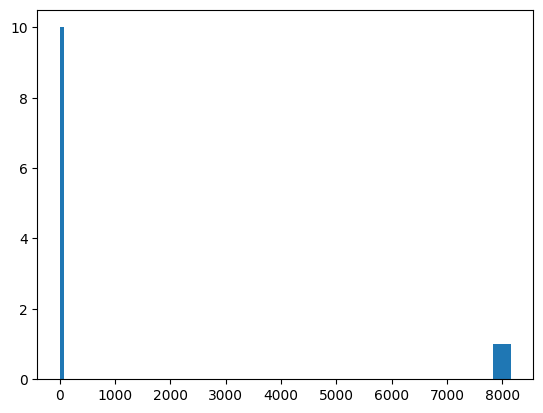

In [4]:
results['rews']
print(np.mean(results['rews'][results['rews'] > -10]))


#create a function  to print a histogram of the results['rews']
import matplotlib.pyplot as plt
plt.hist(results['rews'][results['rews'] > -10], bins=100)
plt.show()
